# Analysis of Leios simulations at branch `bwbush/pre-edi`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
})

## Read results

In [2]:
load("results/rust.R")

### Elapsed time for blocks

In [3]:
receipts %>% summary

 simulator                   network                     label         
 rust:93364090   100-nodes       :69734042   default        :79519885  
                 100-nodes-16cpus: 4726144   extended-voting: 4726144  
                 100-nodes-1cpus : 4726152   oldest-first   : 4356843  
                 100-nodes-2cpus : 4726006   peer-order     : 4761218  
                 100-nodes-4cpus : 4726273                             
                 100-nodes-8cpus : 4725473                             
                                                                       
 leios-stage-length-slots ib-generation-probability ib-body-avg-size-bytes
 Min.   :20.00            Min.   : 1.00             Min.   :98304         
 1st Qu.:20.00            1st Qu.:15.00             1st Qu.:98304         
 Median :20.00            Median :20.00             Median :98304         
 Mean   :31.88            Mean   :17.67             Mean   :98304         
 3rd Qu.:40.00            3rd Qu.:25.00          

### CPU usage

In [4]:
cpus %>% summary

 simulator                   network         leios-stage-length-slots
 rust:16252176   100-nodes       :12204671   Min.   :20.00           
                 100-nodes-16cpus:  809530   1st Qu.:20.00           
                 100-nodes-1cpus :  809726   Median :20.00           
                 100-nodes-2cpus :  809390   Mean   :32.12           
                 100-nodes-4cpus :  809576   3rd Qu.:40.00           
                 100-nodes-8cpus :  809283   Max.   :60.00           
                                                                     
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 1.00             Min.   :98304          Min.   :1.000            
 1st Qu.: 5.00             1st Qu.:98304          1st Qu.:1.500            
 Median :15.00             Median :98304          Median :1.500            
 Mean   :13.52             Mean   :98304          Mean   :1.654            
 3rd Qu.:20.00             3rd Qu.:98304          3rd Qu.:2.

### Scenarios present in dataset

In [5]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)][order(`simulator`, `network`, `label`)]

simulator,network,label,Records
<fct>,<fct>,<fct>,<int>
rust,100-nodes,default,55889837
rust,100-nodes,extended-voting,4726144
rust,100-nodes,oldest-first,4356843
rust,100-nodes,peer-order,4761218
rust,100-nodes-16cpus,default,4726144
rust,100-nodes-1cpus,default,4726152
rust,100-nodes-2cpus,default,4726006
rust,100-nodes-4cpus,default,4726273
rust,100-nodes-8cpus,default,4725473


## Effect of limiting CPU

In [6]:
cpuCase <- function(network) {
    cpuLevels <- c("1 CPU/node", "2 CPUs/node", "4 CPUs/node", "8 CPUs/node", "16 CPUs/node", "Unlimited CPUs")
    if (network == "100-nodes")
        factor("Unlimited CPUs", levels=cpuLevels)
    else if (network == "100-nodes-1cpus")
        factor("1 CPU/node", levels=cpuLevels)
    else if (network == "100-nodes-2cpus")
        factor("2 CPUs/node", levels=cpuLevels)
    else if (network == "100-nodes-4cpus")
        factor("4 CPUs/node", levels=cpuLevels)
    else if (network == "100-nodes-8cpus")
        factor("8 CPUs/node", levels=cpuLevels)
    else if (network == "100-nodes-16cpus")
        factor("16 CPUs/node", levels=cpuLevels)
    else
        null
}

In [7]:
ibRate <- function(rate)
    factor(paste(rate, "IB/s"), levels=c("1 IB/s", "5 IB/s", "10 IB/s", "15 IB/s", "20 IB/s", "25 IB/s"))

In [8]:
cpuLimited <- cpus[
    `label` == "default" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 1.5 &
    `leios-stage-length-slots` == 20,
    .(
        `Total CPU [s/slot/node]`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `CPUs`=mapply(cpuCase, `network`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `Time [s]`=`slot`,
        `node`
    )
]
cpuLimited %>% summary

 simulator                  CPUs           IB Rate          Time [s]    
 rust:2114805   1 CPU/node    :352469   1 IB/s :314925   Min.   :  0.0  
                2 CPUs/node   :352468   5 IB/s :359880   1st Qu.:149.0  
                4 CPUs/node   :352467   10 IB/s:360000   Median :298.0  
                8 CPUs/node   :352467   15 IB/s:360000   Mean   :298.8  
                16 CPUs/node  :352467   20 IB/s:360000   3rd Qu.:449.0  
                Unlimited CPUs:352467   25 IB/s:360000   Max.   :600.0  
                                                                        
      node         Total CPU [s/slot/node]
 node-20:  21234   Min.   :0.000164       
 node-5 :  21222   1st Qu.:0.505520       
 node-90:  21216   Median :1.296952       
 node-4 :  21210   Mean   :1.276299       
 node-84:  21210   3rd Qu.:2.010080       
 node-49:  21204   Max.   :3.430032       
 (Other):1987509                          

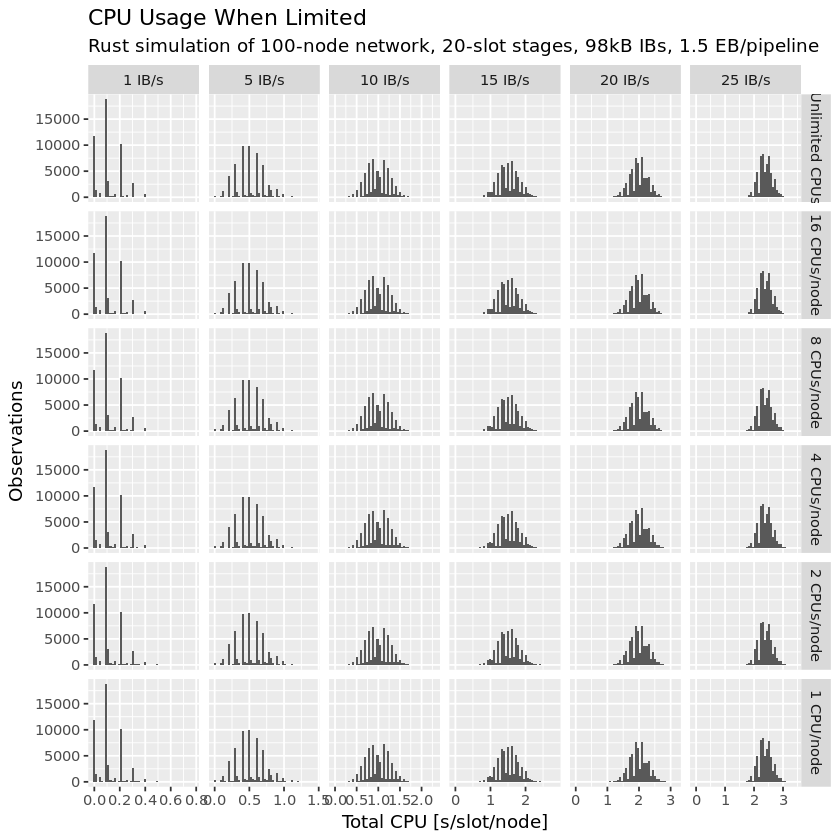

In [9]:
for (s in cpuLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(cpuLimited[`simulator` == s], aes(x=`Total CPU [s/slot/node]`)) +
        geom_histogram(bins=50) +
        facet_grid(factor(`CPUs`, levels=levels(`CPUs`)%>%rev) ~ `IB Rate`, scales="free") +
        ylab("Observations") +
        ggtitle("CPU Usage When Limited", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/cpu-limited-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

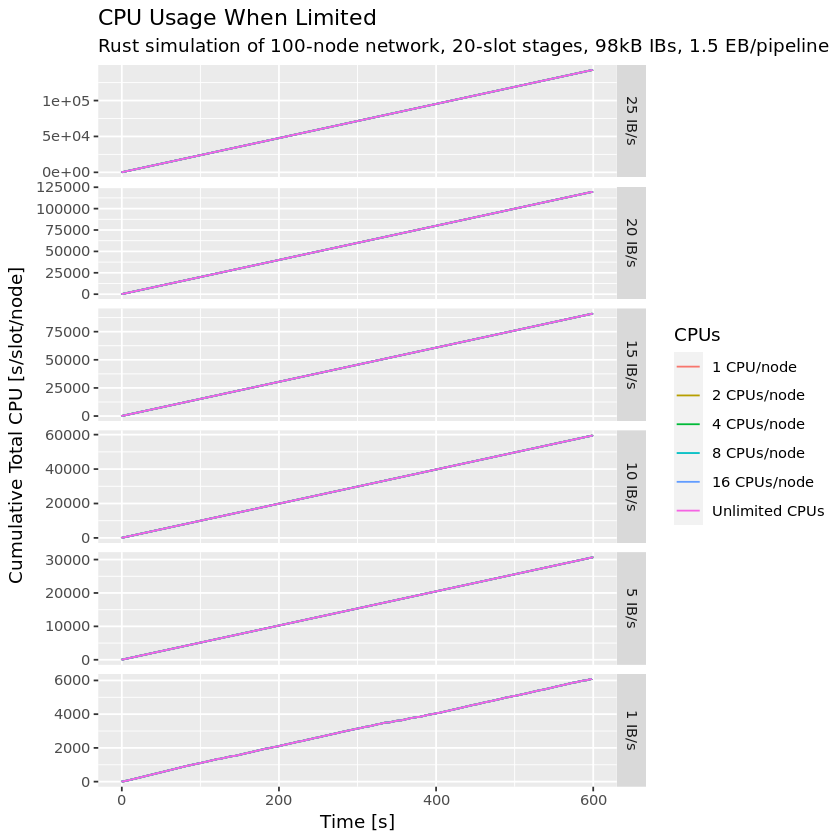

In [10]:
for (s in cpuLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        cpuLimited[
            `simulator` == s, .(`Time [s]`, `Total CPU [s/slot/node]`=mean(`Total CPU [s/slot/node]`)), by=.(`CPUs`, `IB Rate`)
        ][
            order(`CPUs`, `IB Rate`, `Time [s]`)
        ][, .(`Time [s]`, `Cumulative Total CPU [s/slot/node]`=cumsum(`Total CPU [s/slot/node]`)), by=.(`CPUs`, `IB Rate`)],
        aes(x=`Time [s]`, y=`Cumulative Total CPU [s/slot/node]`, color=`CPUs`)
    ) +
        geom_line() +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ ., scales="free_y") +
        ggtitle("CPU Usage When Limited", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/cpu-limited-cumulative-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [11]:
receiptLimited <- receipts[
    `label` == "default" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 1.5 &
    `leios-stage-length-slots` == 20 &
    `kind` == "IB",
    .(
        `simulator`,
        `CPUs`=mapply(cpuCase, `network`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptLimited %>% summary

 simulator                   CPUs            IB Rate           elapsed       
 rust:26737736   1 CPU/node    :4455976   1 IB/s : 347400   Min.   :  0.000  
                 2 CPUs/node   :4456530   5 IB/s :1815600   1st Qu.:  1.352  
                 4 CPUs/node   :4456397   10 IB/s:3533402   Median :  1.952  
                 8 CPUs/node   :4456097   15 IB/s:5418521   Mean   :  2.168  
                 16 CPUs/node  :4456368   20 IB/s:7126878   3rd Qu.:  2.662  
                 Unlimited CPUs:4456368   25 IB/s:8495935   Max.   :339.173  
                                                                             
           item               sent           received     
 0-node-22-0 :    3000   Min.   :  0.13   Min.   :  0.13  
 0-node-32-0 :    3000   1st Qu.:151.13   1st Qu.:153.24  
 0-node-69-0 :    3000   Median :301.13   Median :303.79  
 0-node-89-0 :    3000   Mean   :301.01   Mean   :303.18  
 1-node-90-0 :    3000   3rd Qu.:451.13   3rd Qu.:453.79  
 54-node-23-0:    3000

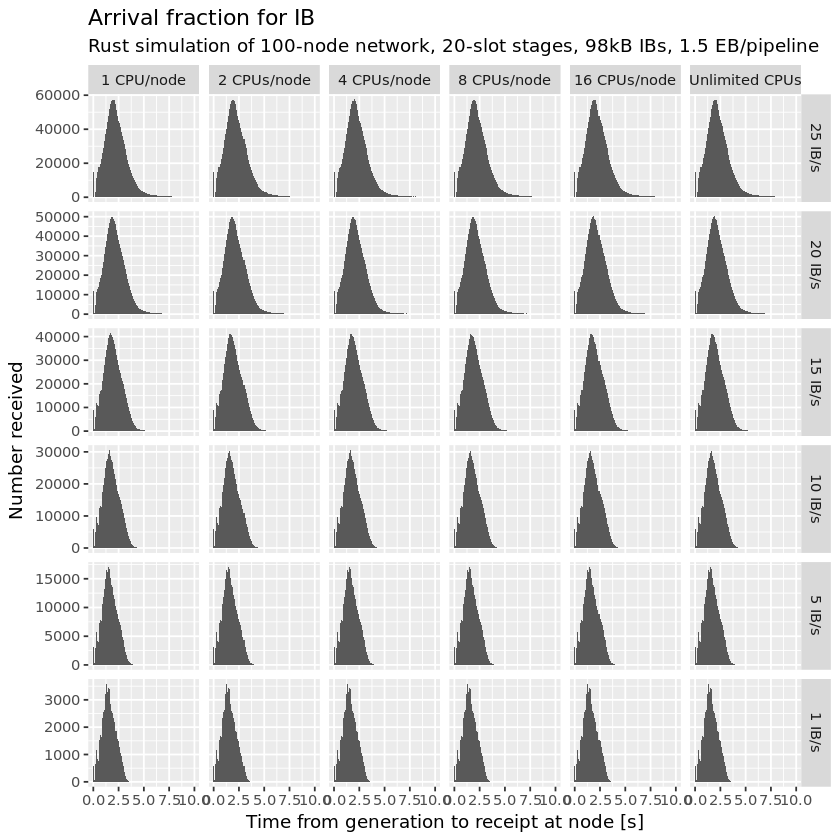

In [12]:
for (s in receiptLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptLimited[`simulator` == s], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `CPUs`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/receipt-limited-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [13]:
arrivalLimited <- receiptLimited[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`)
]

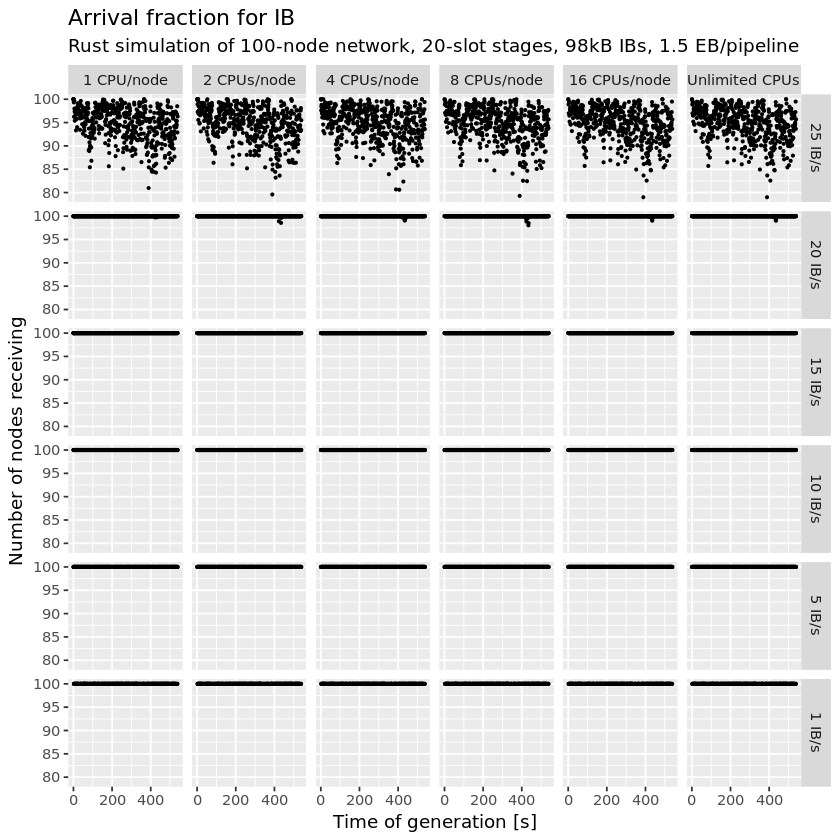

In [14]:
for (s in arrivalLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalLimited[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `CPUs`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
    print(g)
    ggsave(paste0("plots/arrival-limited-IB-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## Effect of delivery order

In [15]:
orderCase <- function(label) {
    labelLevels <- c("oldest-first", "peer-order", "freshest-first")
    if (label == "default")
        factor("freshest-first", levels=labelLevels)
    else
        factor(label, levels=labelLevels)
}    

In [16]:
receiptOrdered <- receipts[
    `label` %in% c("default", "oldest-first", "peer-order") &
    `network` == "100-nodes" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 1.5 &
    `leios-stage-length-slots` == 20 &
    `kind` == "IB",
    .(
        `simulator`,
        `Ordering`=mapply(orderCase, `label`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptOrdered %>% summary

 simulator                 Ordering          IB Rate           elapsed       
 rust:13034377   oldest-first  :4089767   1 IB/s : 173700   Min.   :  0.000  
                 peer-order    :4488242   5 IB/s : 907791   1st Qu.:  1.449  
                 freshest-first:4456368   10 IB/s:1766504   Median :  2.194  
                                          15 IB/s:2692864   Mean   :  9.421  
                                          20 IB/s:3445189   3rd Qu.:  3.260  
                                          25 IB/s:4048329   Max.   :286.211  
                                                                             
           item               sent           received     
 0-node-22-0 :    1500   Min.   :  0.13   Min.   :  0.13  
 0-node-32-0 :    1500   1st Qu.:146.13   1st Qu.:153.49  
 0-node-69-0 :    1500   Median :292.13   Median :303.73  
 0-node-89-0 :    1500   Mean   :293.74   Mean   :303.17  
 1-node-90-0 :    1500   3rd Qu.:438.13   3rd Qu.:453.62  
 54-node-23-0:    1500

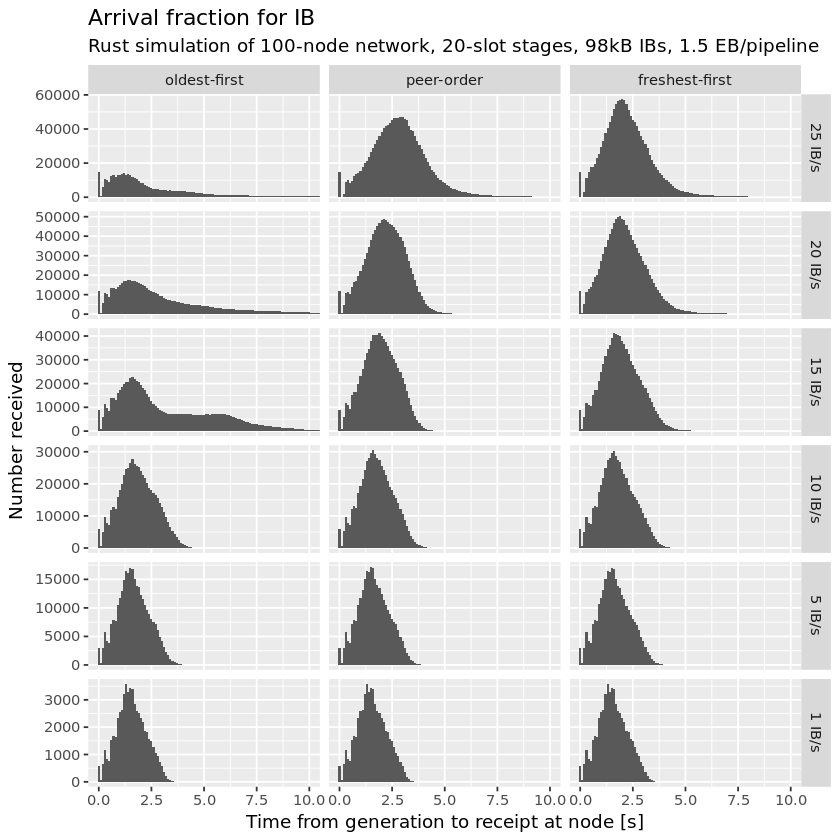

In [17]:
for (s in receiptOrdered[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptOrdered[`simulator` == s], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `Ordering`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/receipt-ordered-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [18]:
arrivalOrdered <- receiptOrdered[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`)
]

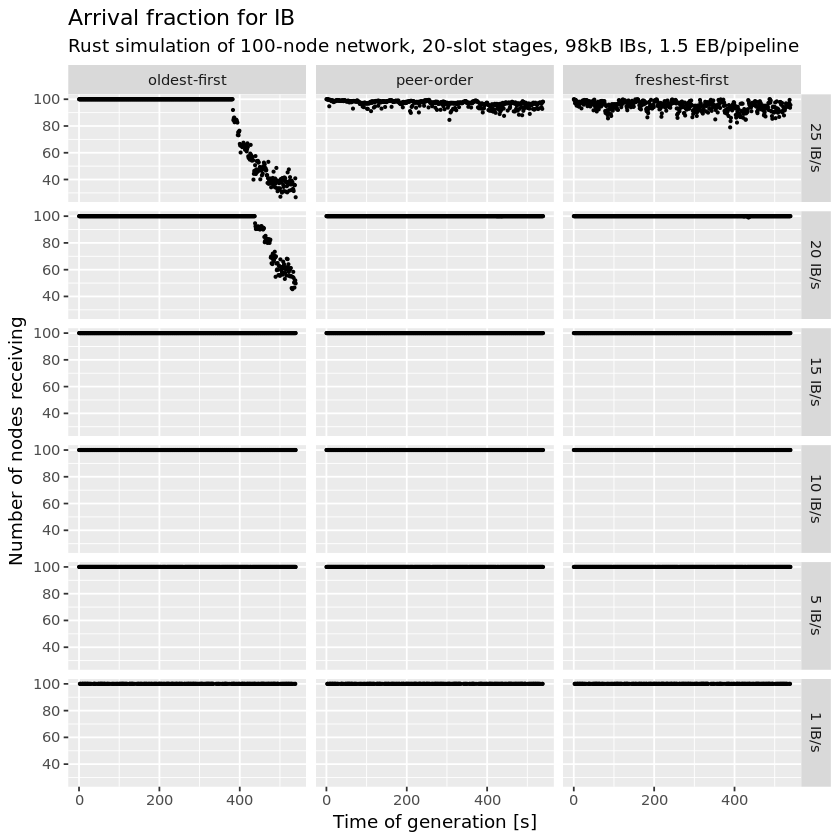

In [19]:
for (s in arrivalOrdered[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalOrdered[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `Ordering`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
    print(g)
    ggsave(paste0("plots/arrival-ordered-IB-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## Effect of extended voting

In [20]:
extendedCase <- function(label) {
    labelLevels <- c("Without extended voting", "With extended voting")
    if (label == "default")
        factor("Without extended voting", levels=labelLevels)
    else if (label == "extended-voting")
        factor("With extended voting", levels=labelLevels)
    else
        null
}    

In [21]:
receiptExtended <- receipts[
    `label` %in% c("default", "extended-voting") &
    `network` == "100-nodes" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 1.5 &
    `leios-stage-length-slots` == 20 &
    `kind` == "VT",
    .(
        `simulator`,
        `Extended`=mapply(extendedCase, `label`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptExtended %>% summary

 simulator                        Extended         IB Rate     
 rust:447000   Without extended voting:223500   1 IB/s :81200  
               With extended voting   :223500   5 IB/s :81200  
                                                10 IB/s:82400  
                                                15 IB/s:78200  
                                                20 IB/s:82600  
                                                25 IB/s:41400  
                                                               
    elapsed                item             sent          received     
 Min.   :0.0000   20-node-22 :   600   Min.   : 20.0   Min.   : 20.00  
 1st Qu.:0.5204   47-node-46 :   600   1st Qu.: 38.0   1st Qu.: 39.08  
 Median :0.8327   500-node-17:   600   Median : 57.0   Median : 58.16  
 Mean   :0.8852   68-node-86 :   600   Mean   :116.7   Mean   :117.54  
 3rd Qu.:1.2287   72-node-7  :   600   3rd Qu.: 79.0   3rd Qu.: 79.52  
 Max.   :2.4120   77-node-80 :   600   Max.   :580.0   M

In [22]:
receiptExtended[,
    .(`Mean time from generation to receipt at node [s]`=mean(`elapsed`, na.rm=TRUE)),
    by=.(`simulator`, `Extended`)
]

simulator,Extended,Mean time from generation to receipt at node [s]
<fct>,<fct>,<dbl>
rust,Without extended voting,0.88522
rust,With extended voting,0.88522


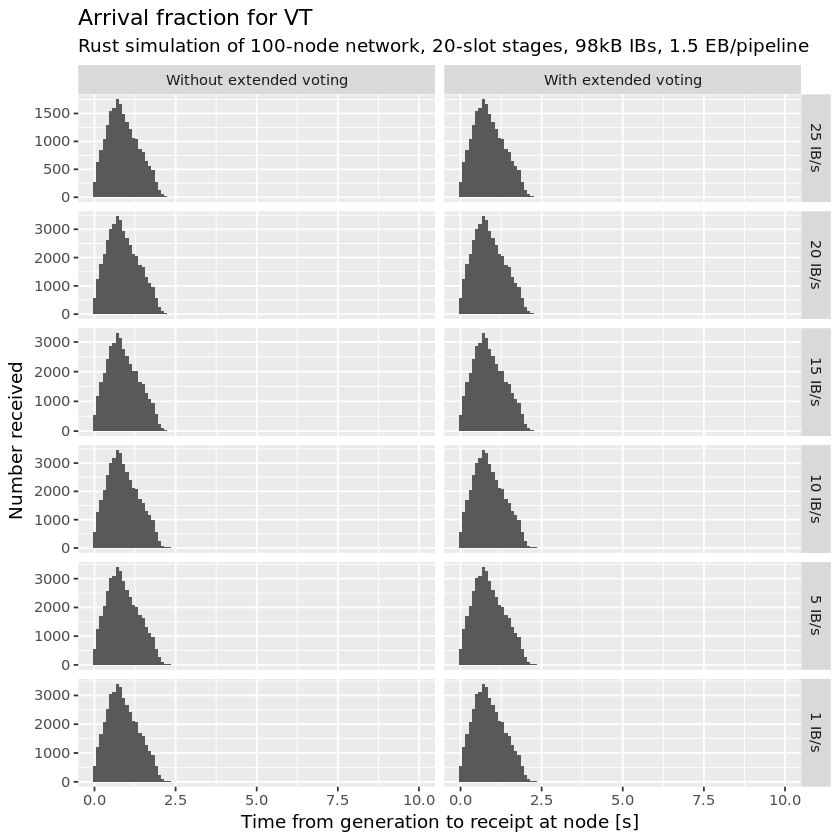

In [23]:
for (s in receiptExtended[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptExtended[`simulator` == s & !is.na(`elapsed`)], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `Extended`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for VT", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/receipt-ordered-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [24]:
arrivalExtended <- receiptExtended[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`)
]

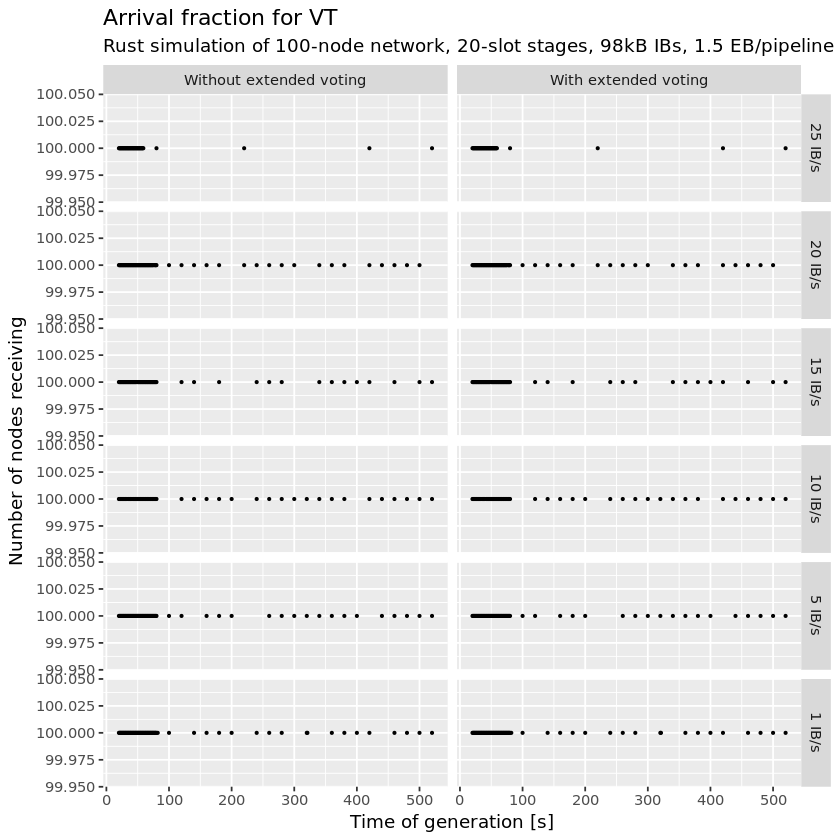

In [25]:
for (s in arrivalExtended[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalExtended[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `Extended`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for VT", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
    print(g)
    ggsave(paste0("plots/arrival-extended-VT-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## General diagnostics

#### Compare the distributions of elapsed times

In [26]:
receiptScenario <- receipts[
    order(`simulator`, `label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`)
][
    !is.na(`elapsed`),
    .(`elapsed`),
    .(
        `simulator`,
        `scenario`=paste(`label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`, sep=" | "),
        `kind`
    )
]

In [27]:
options(repr.plot.width=20, repr.plot.height=15)

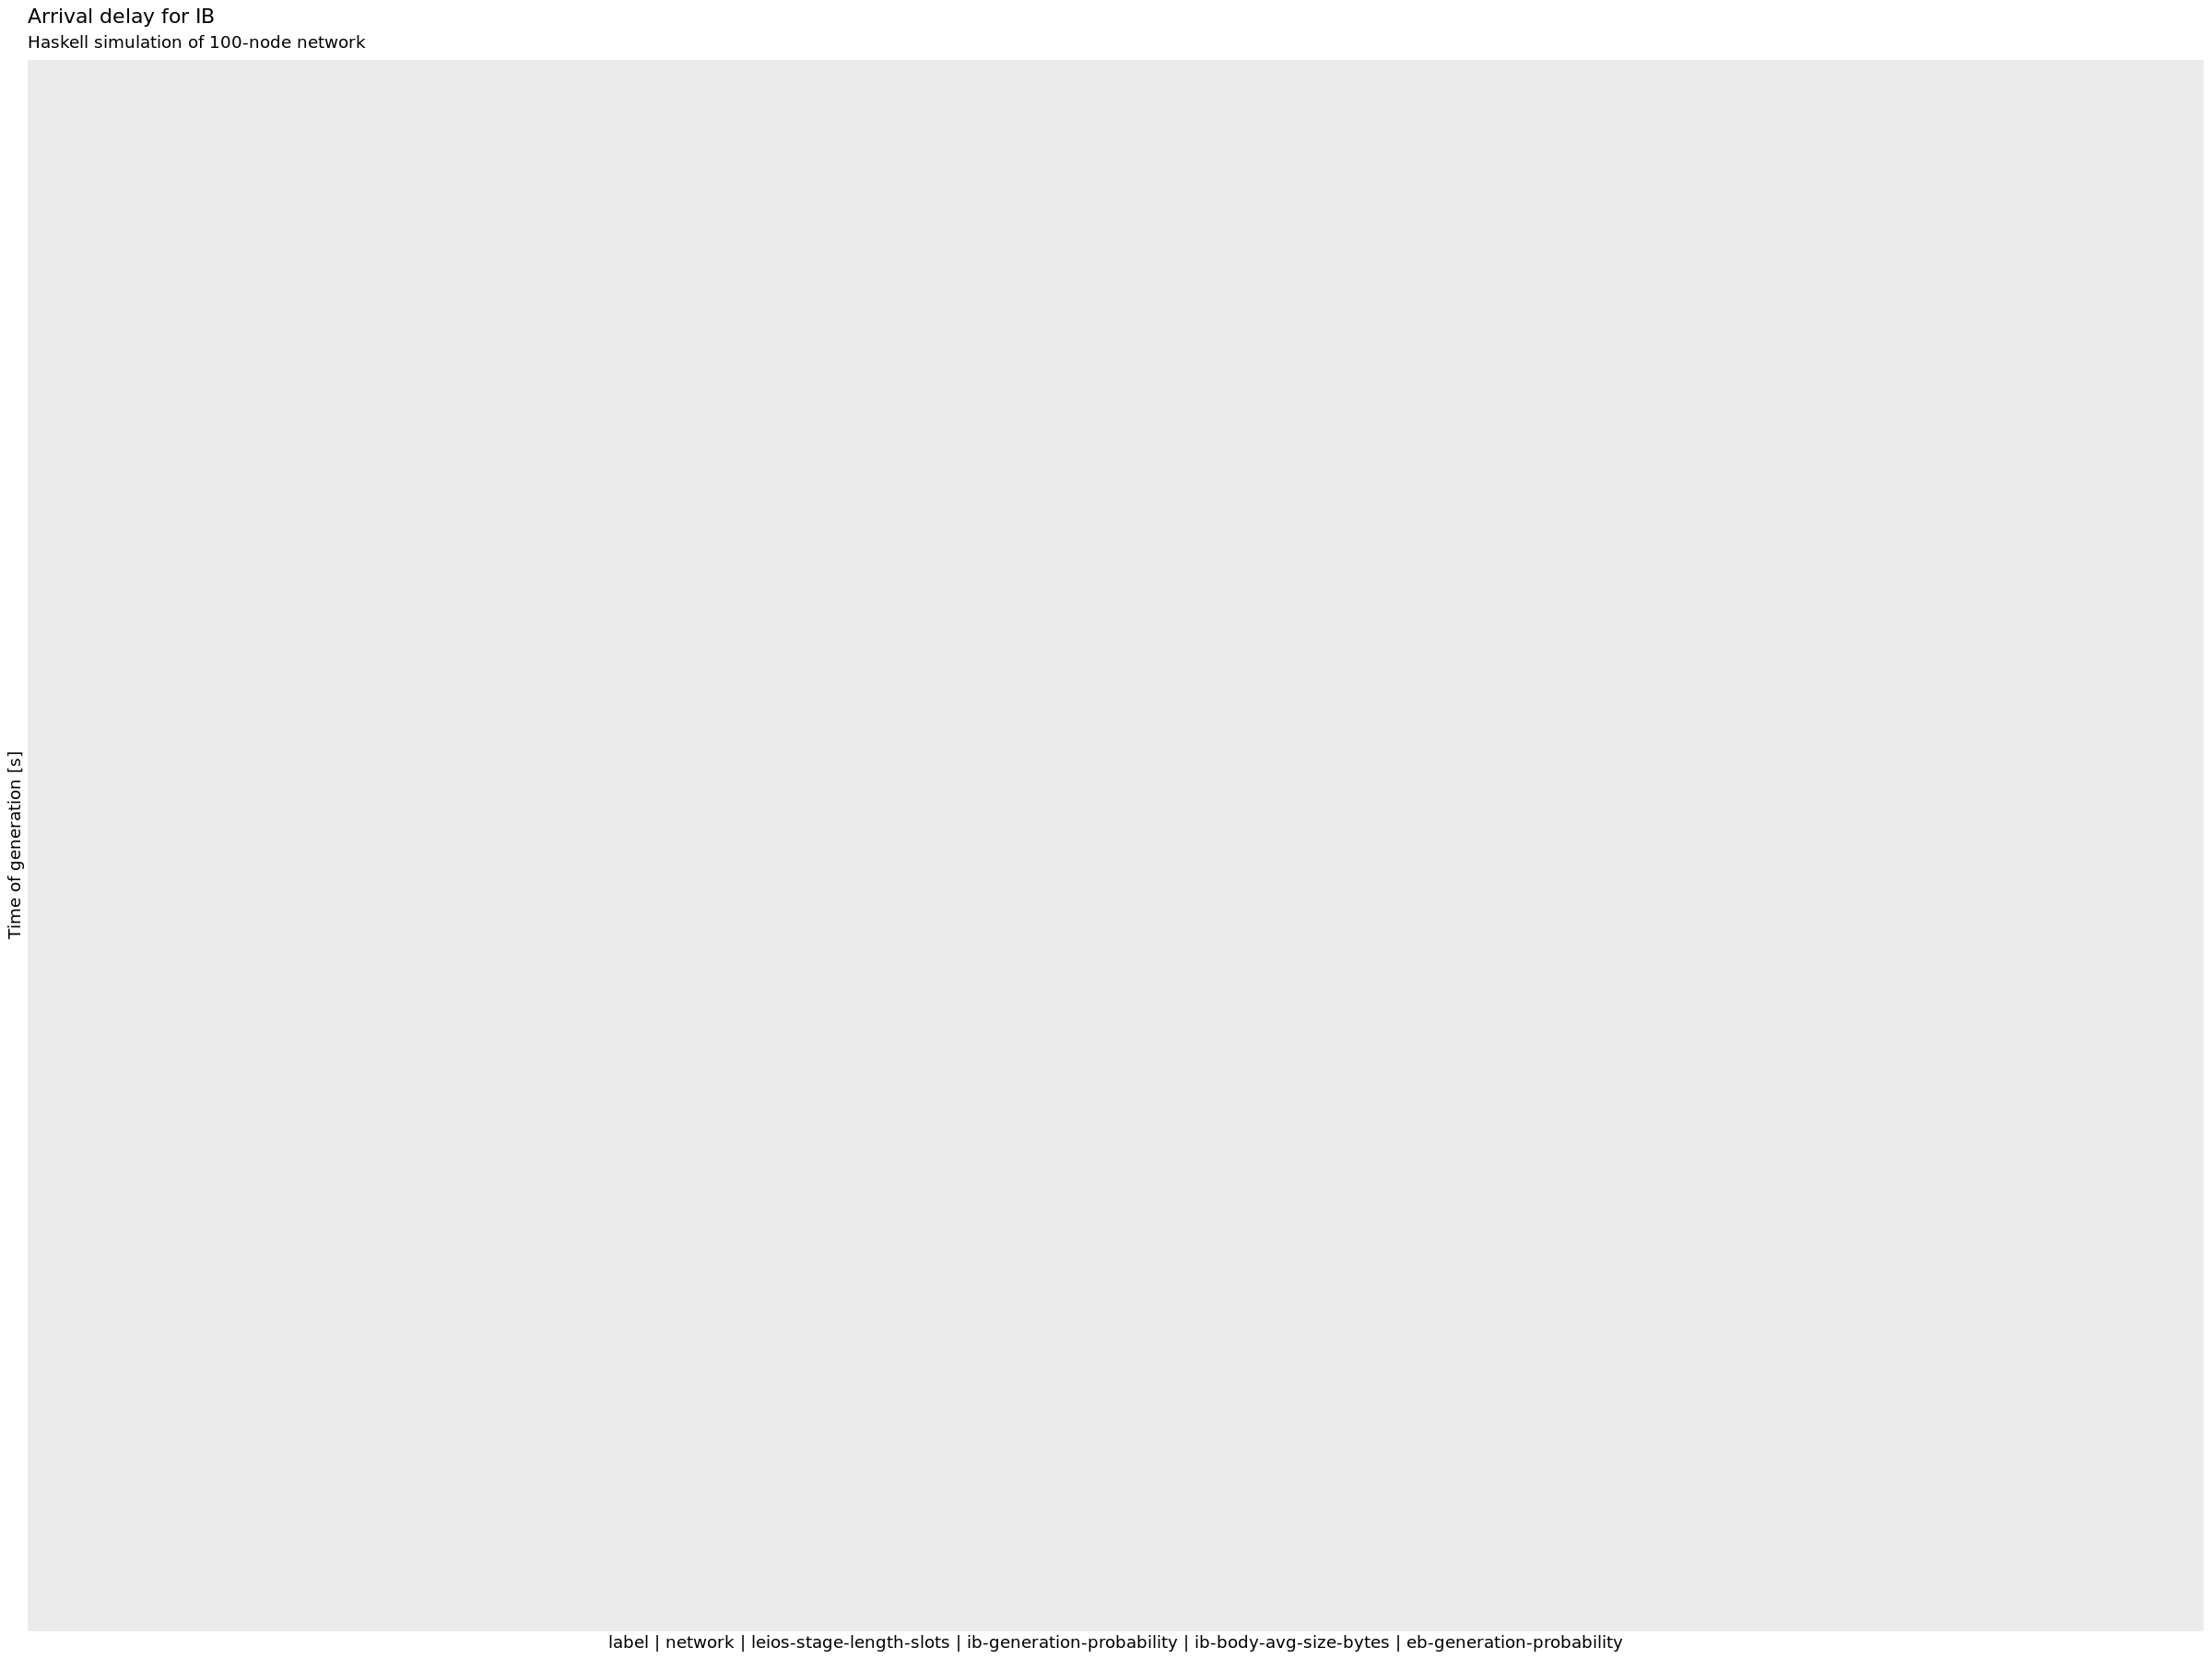

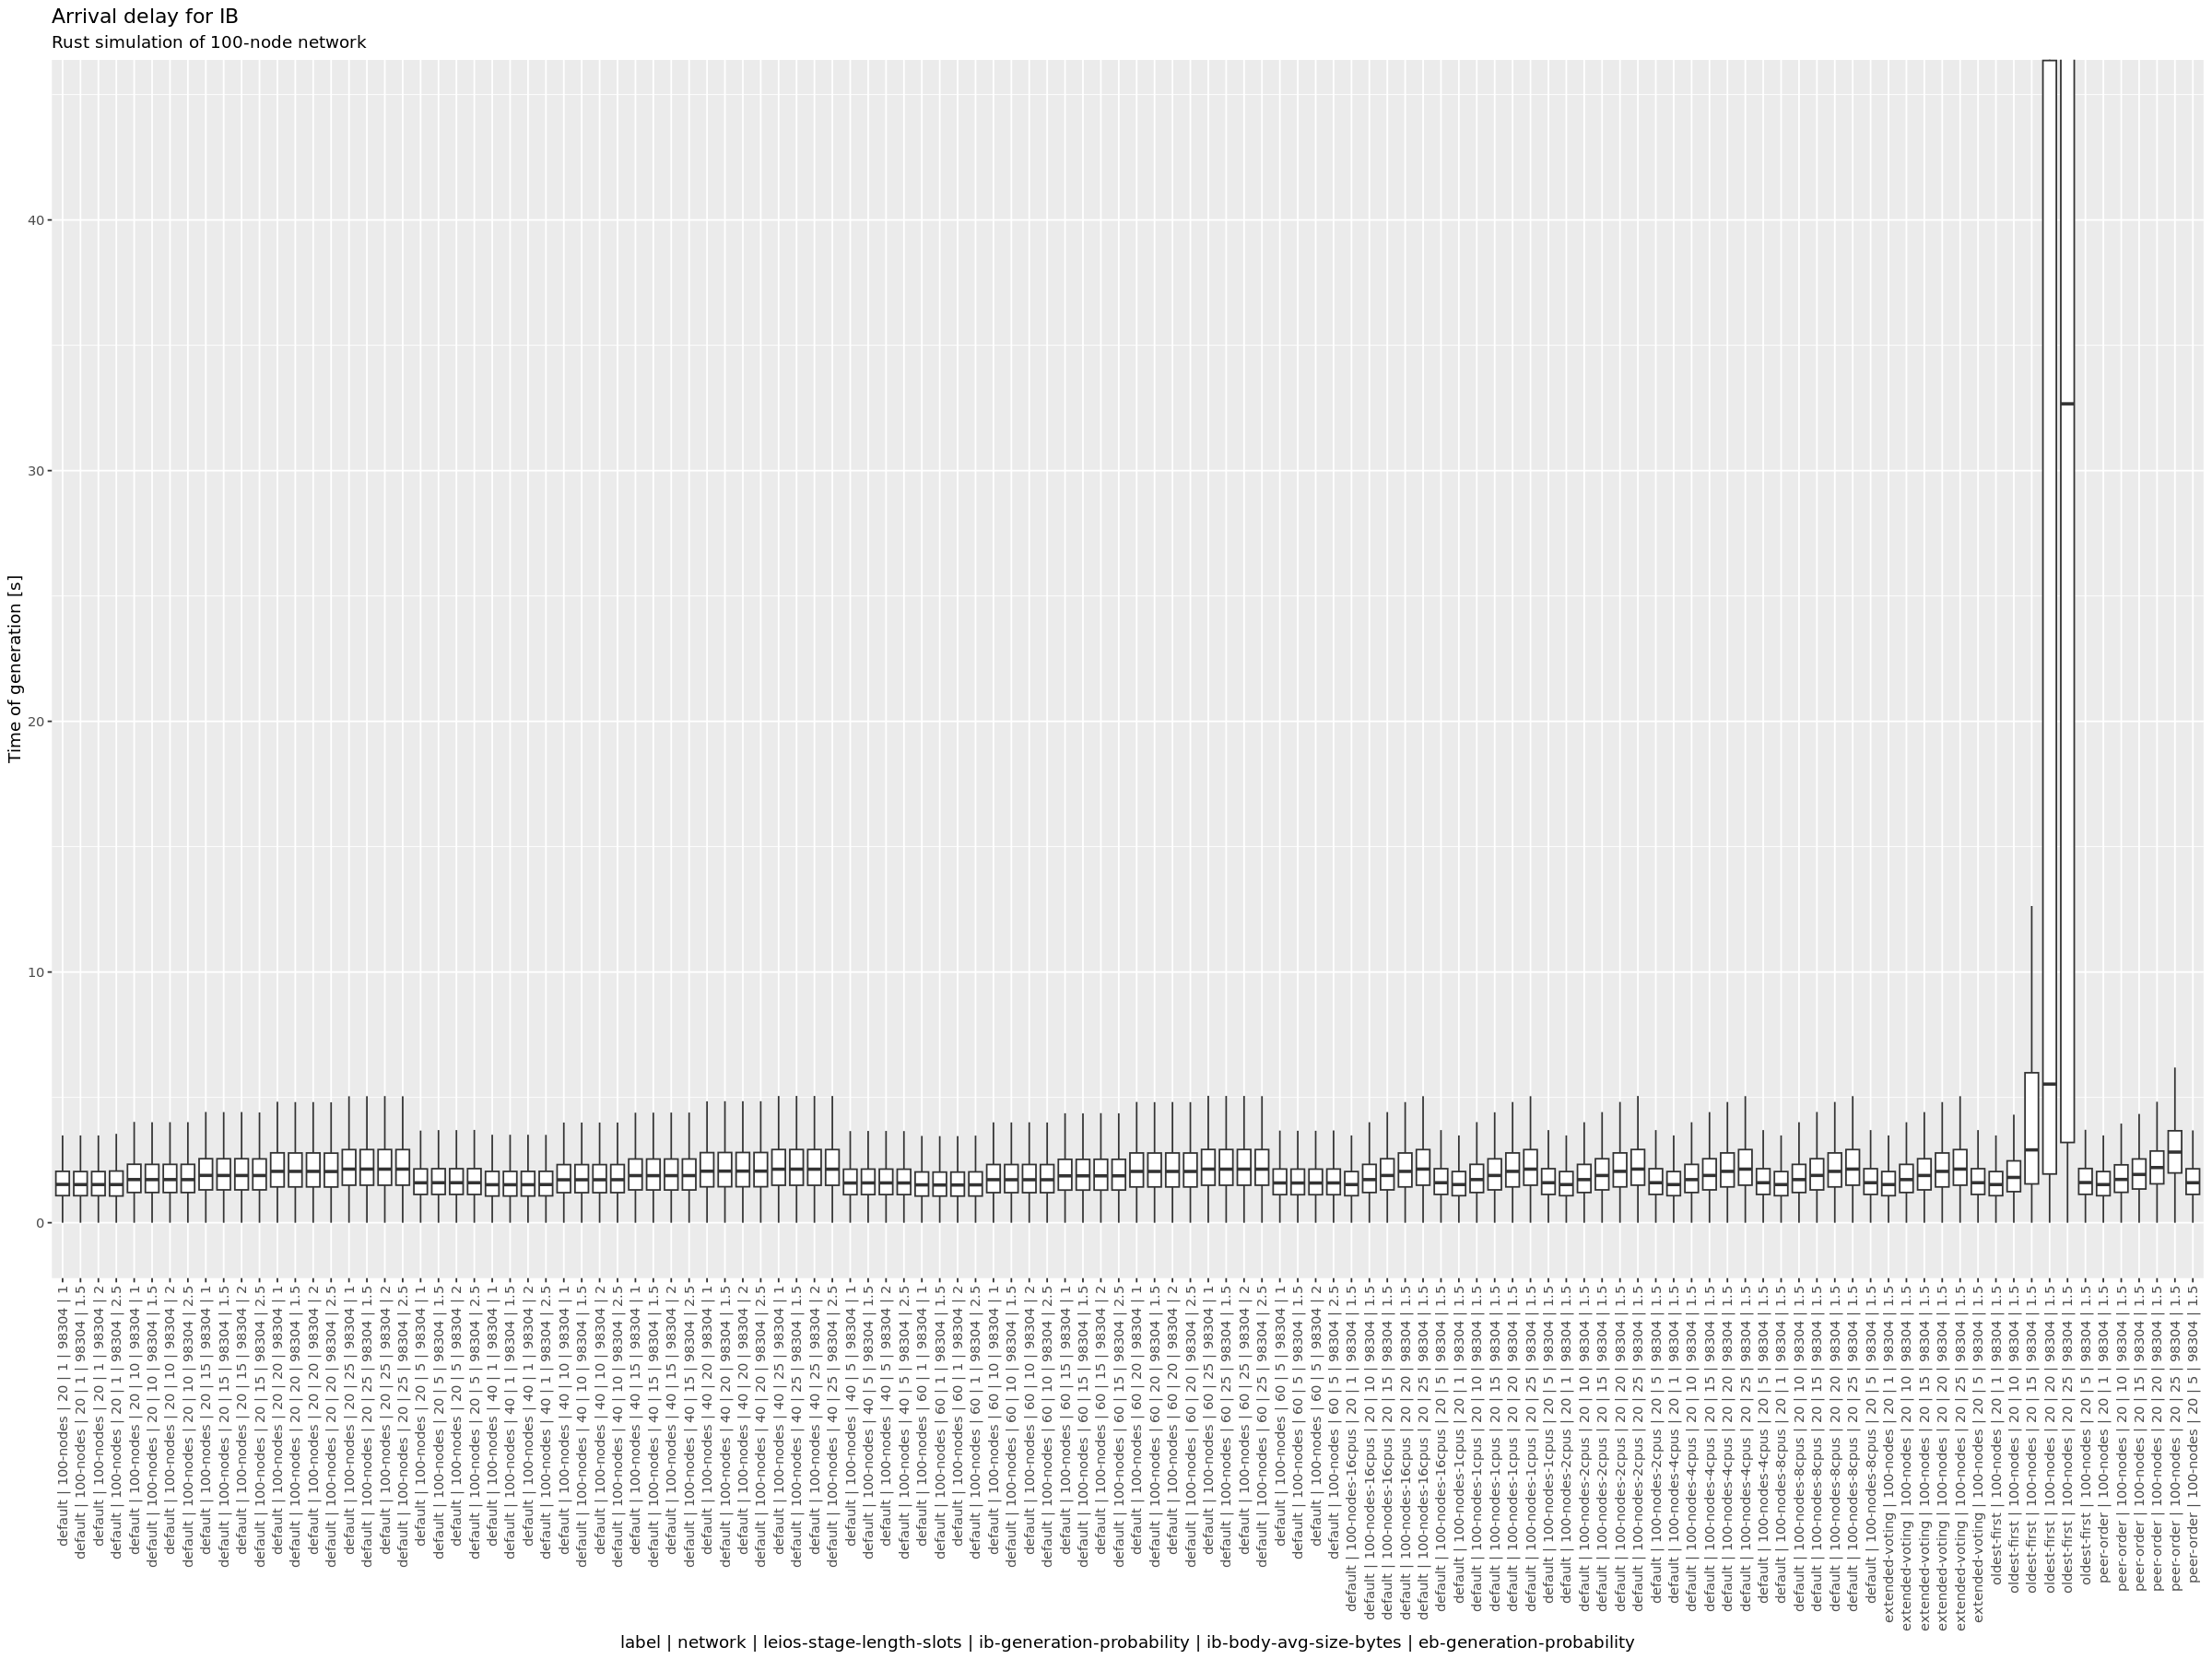

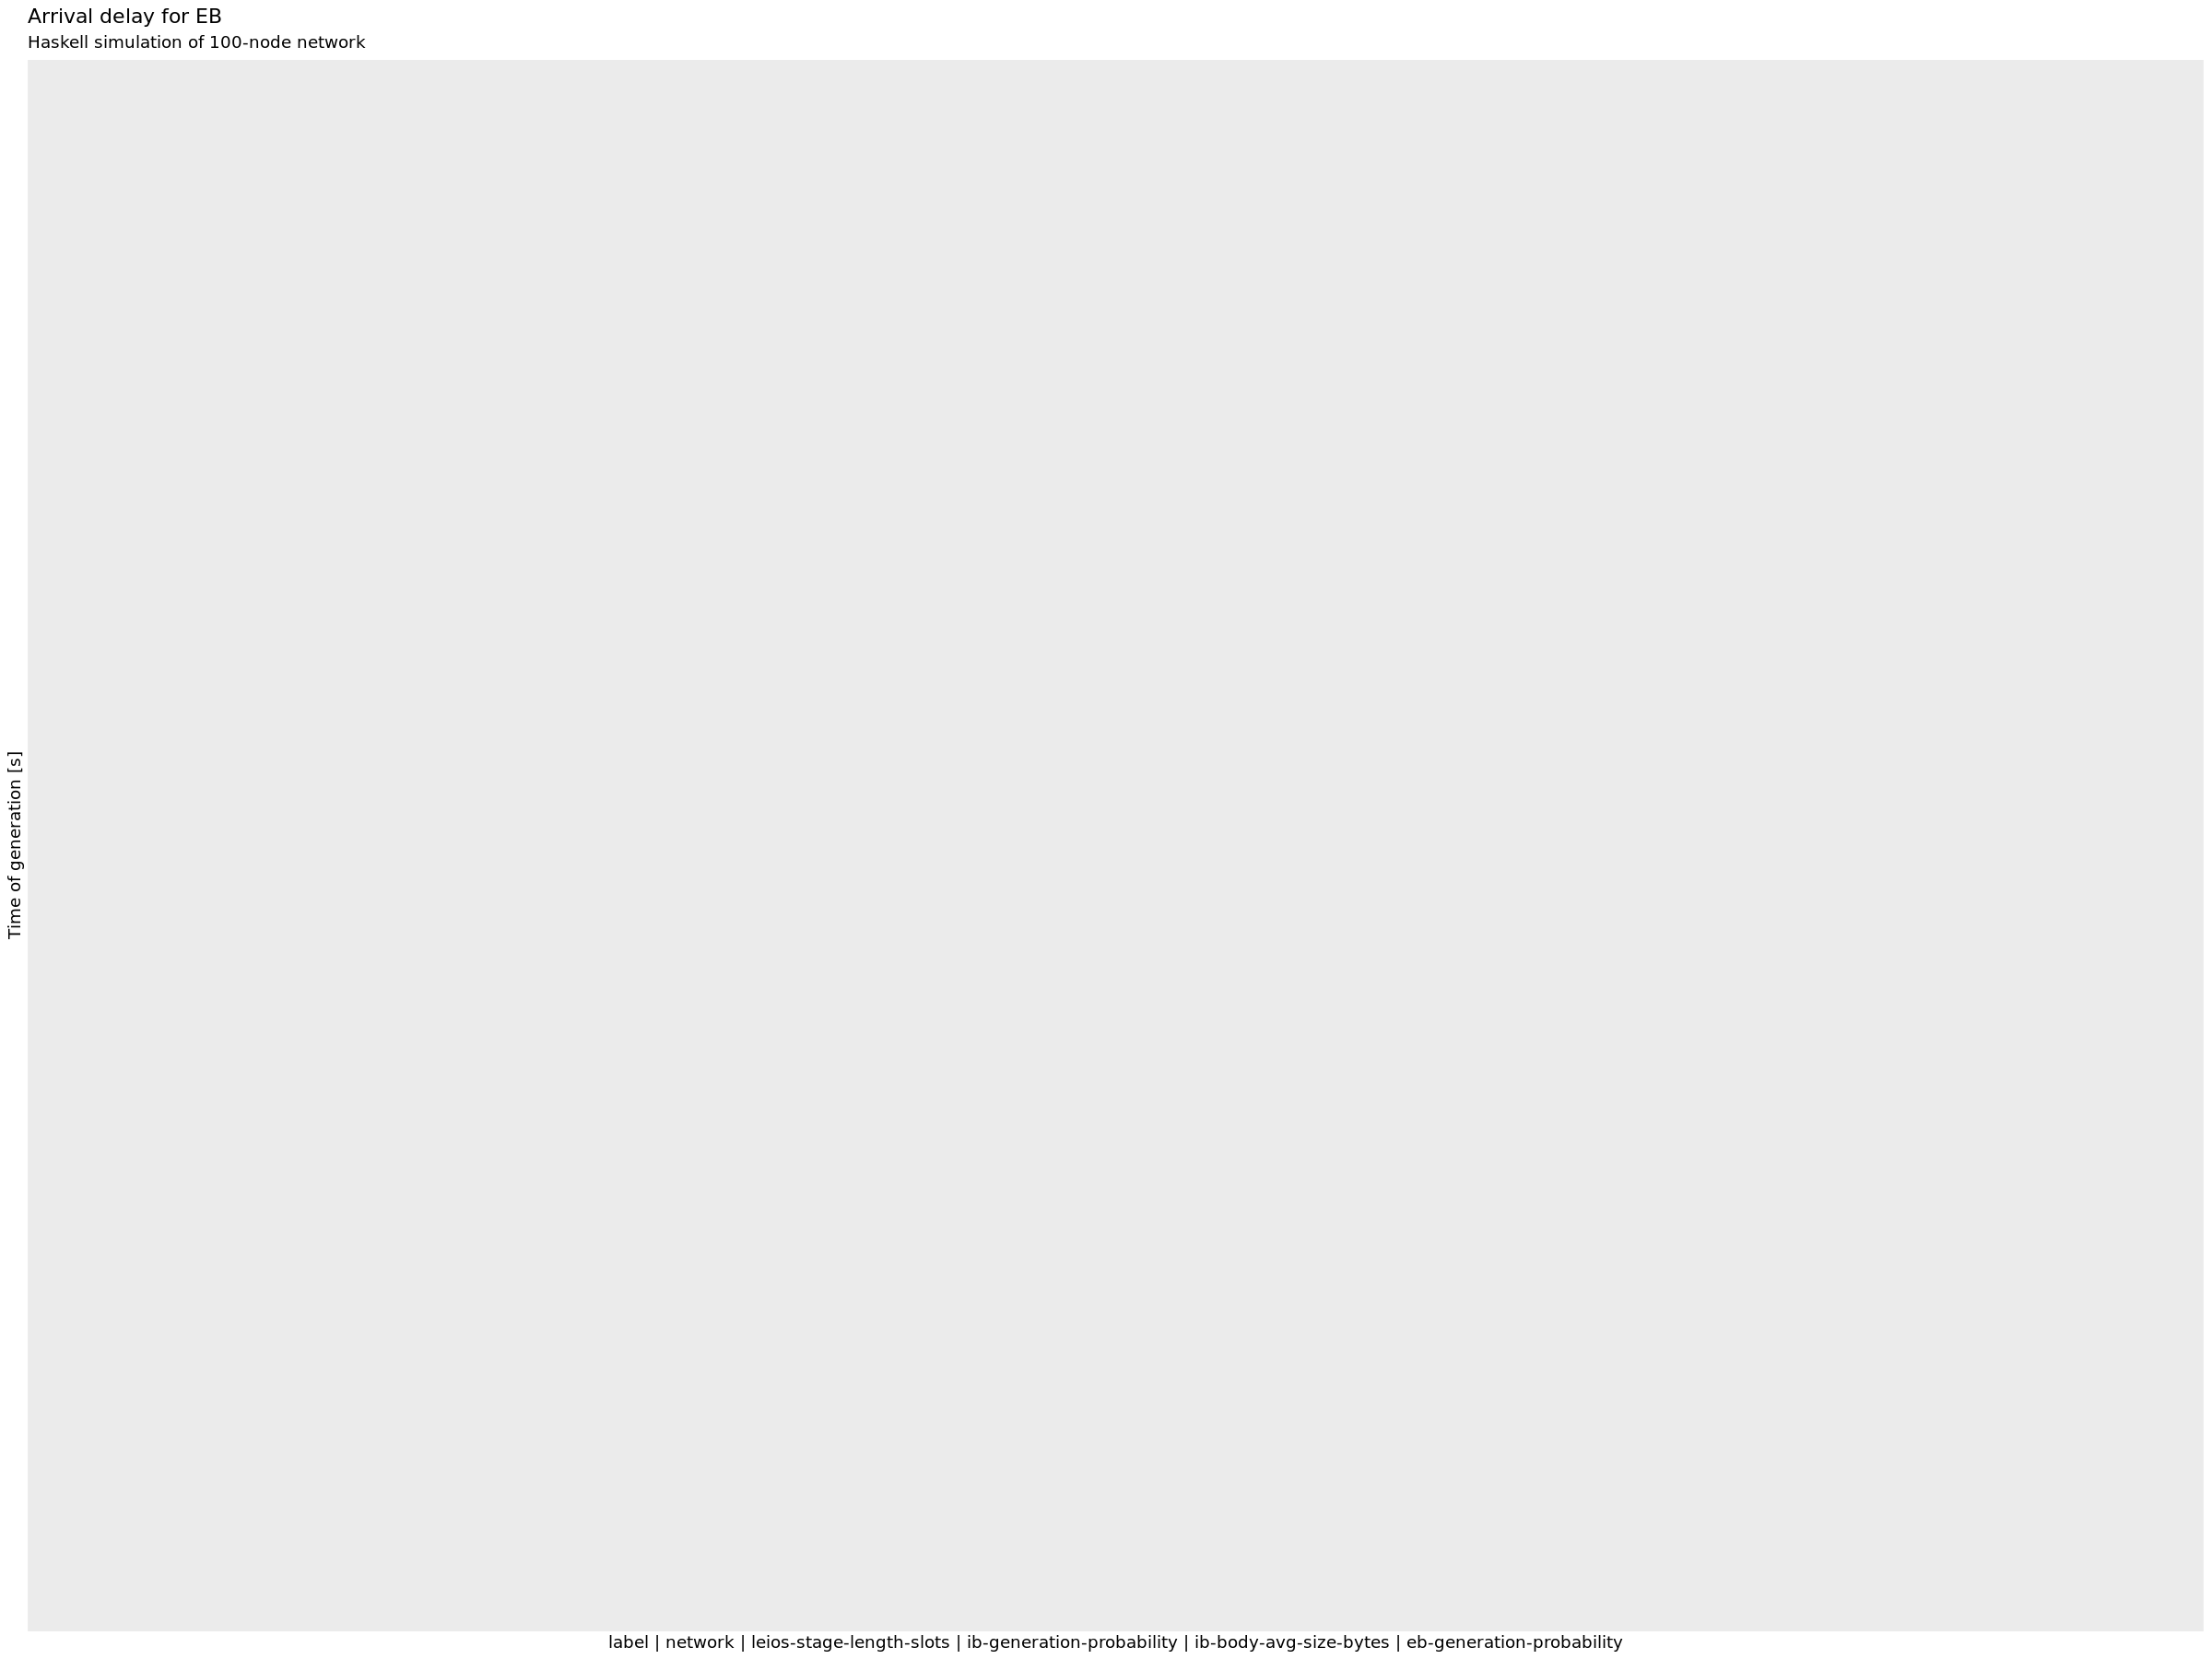

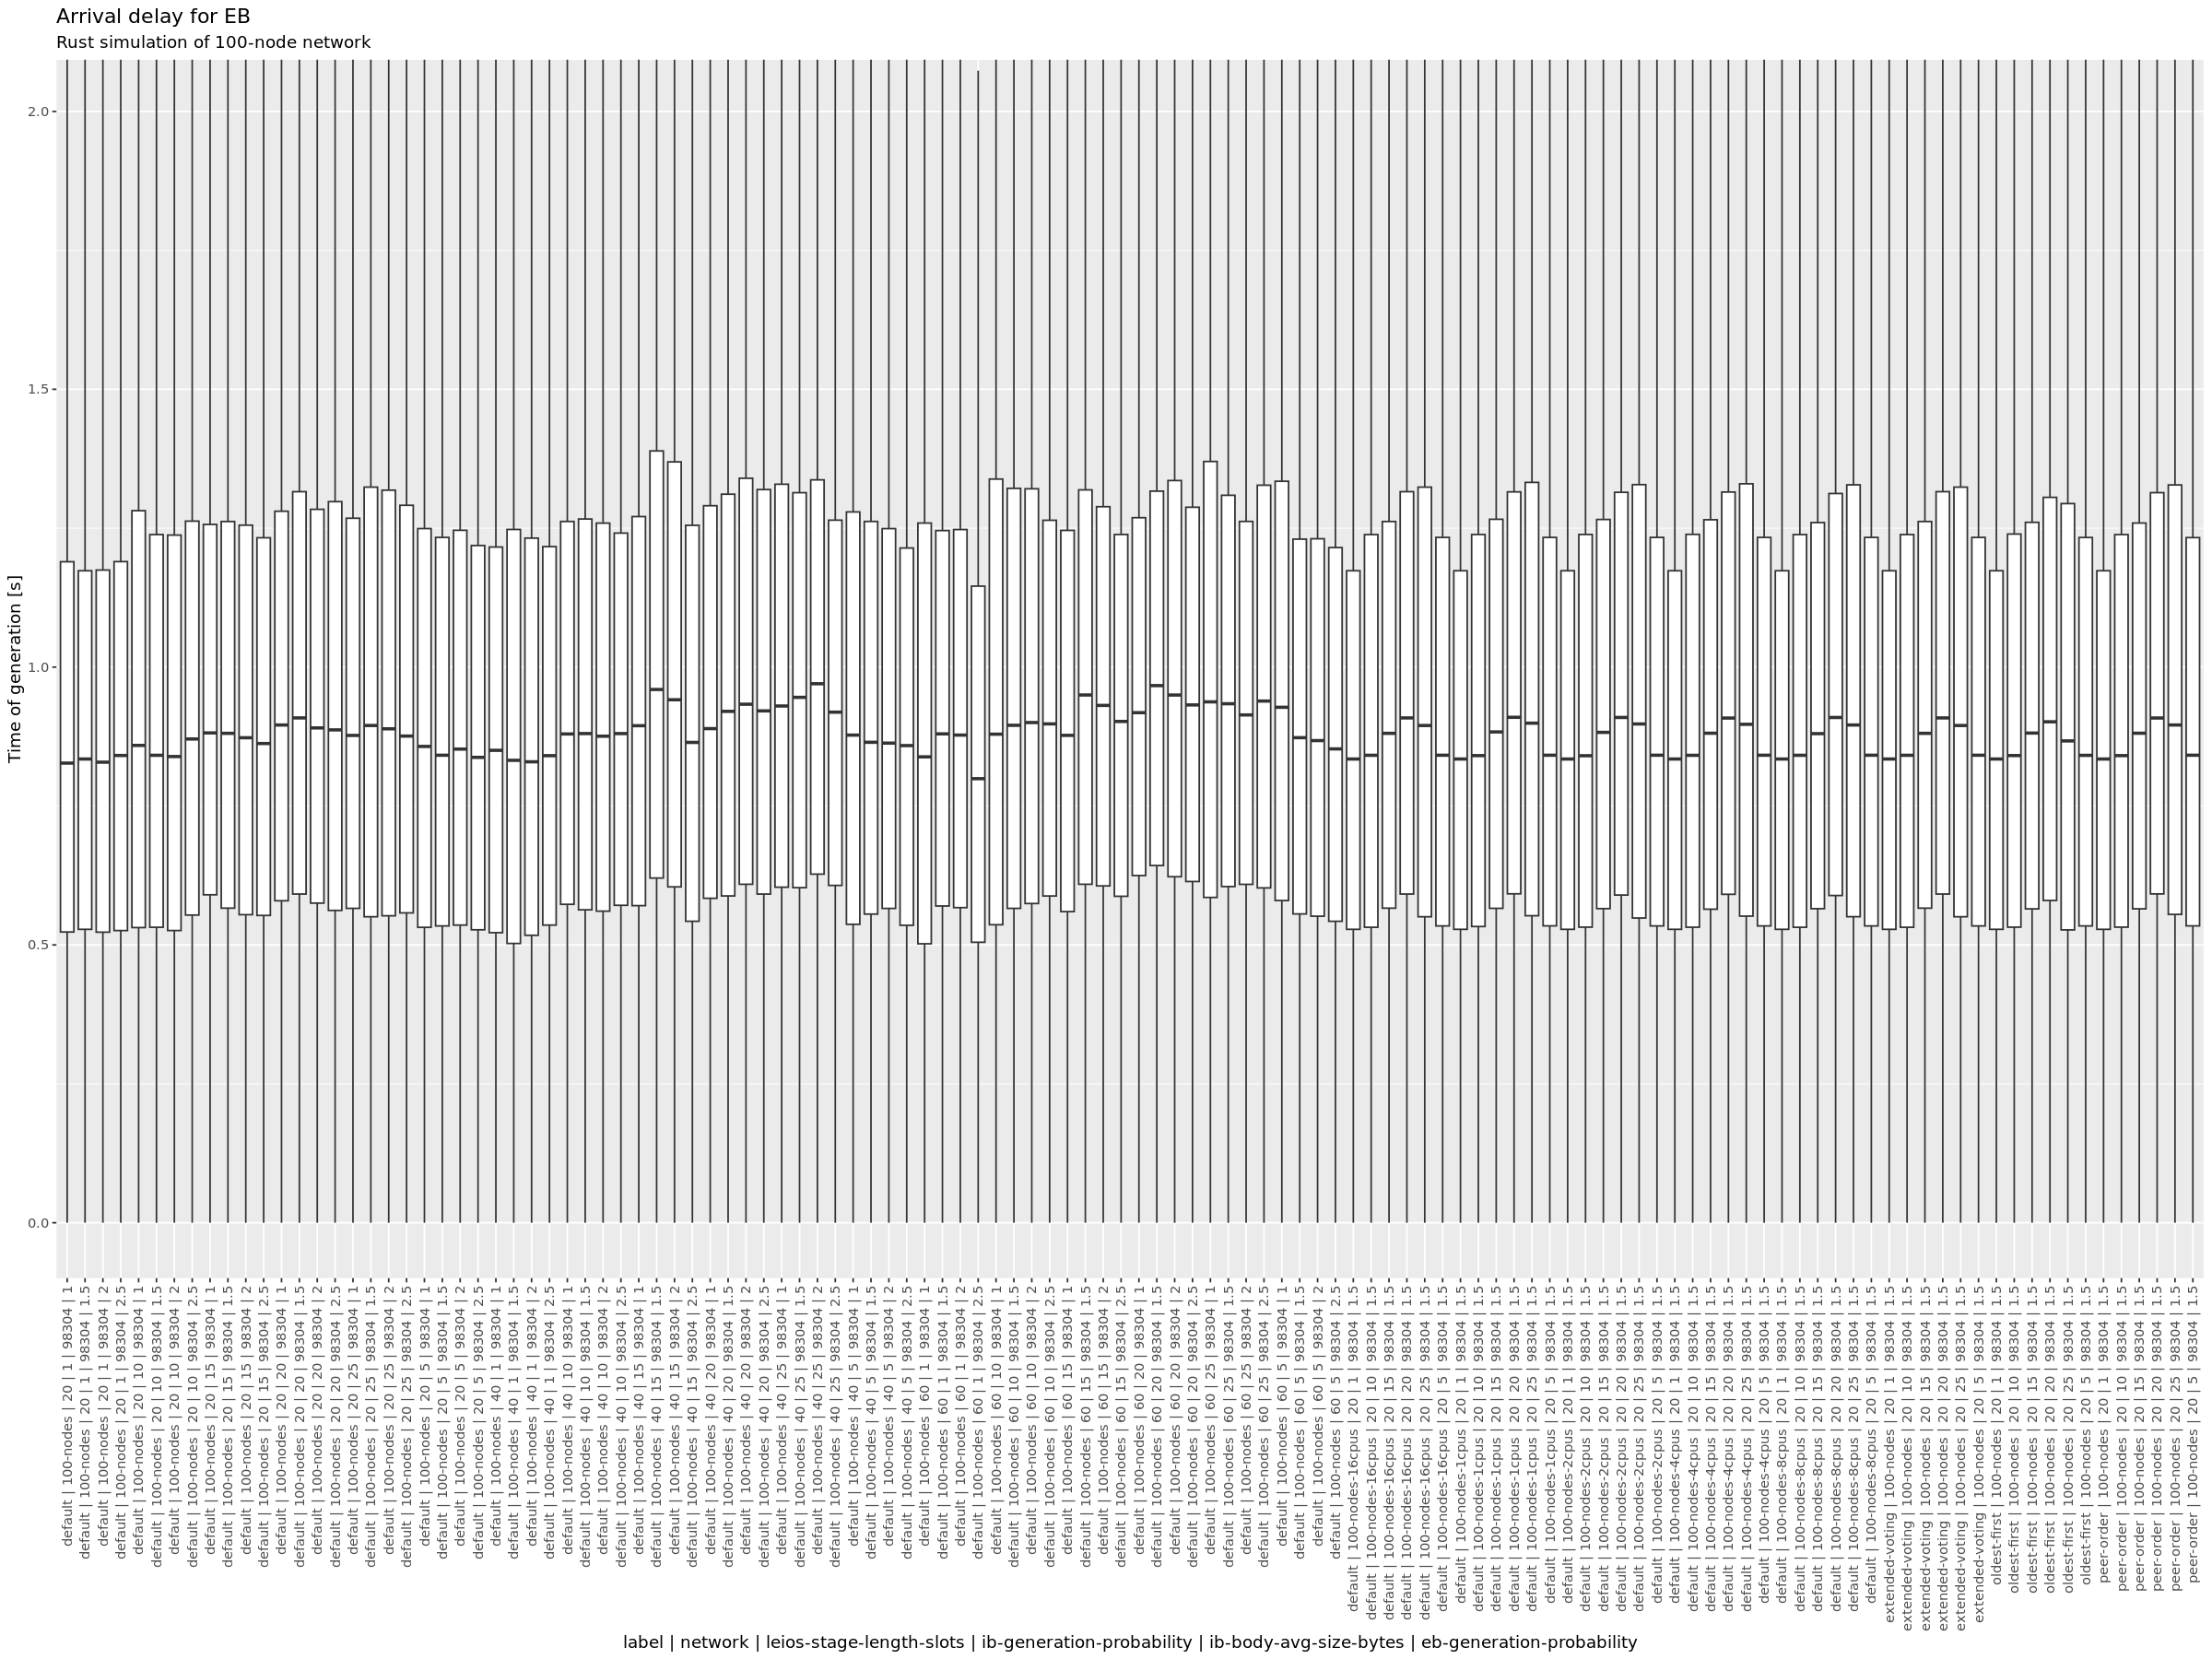

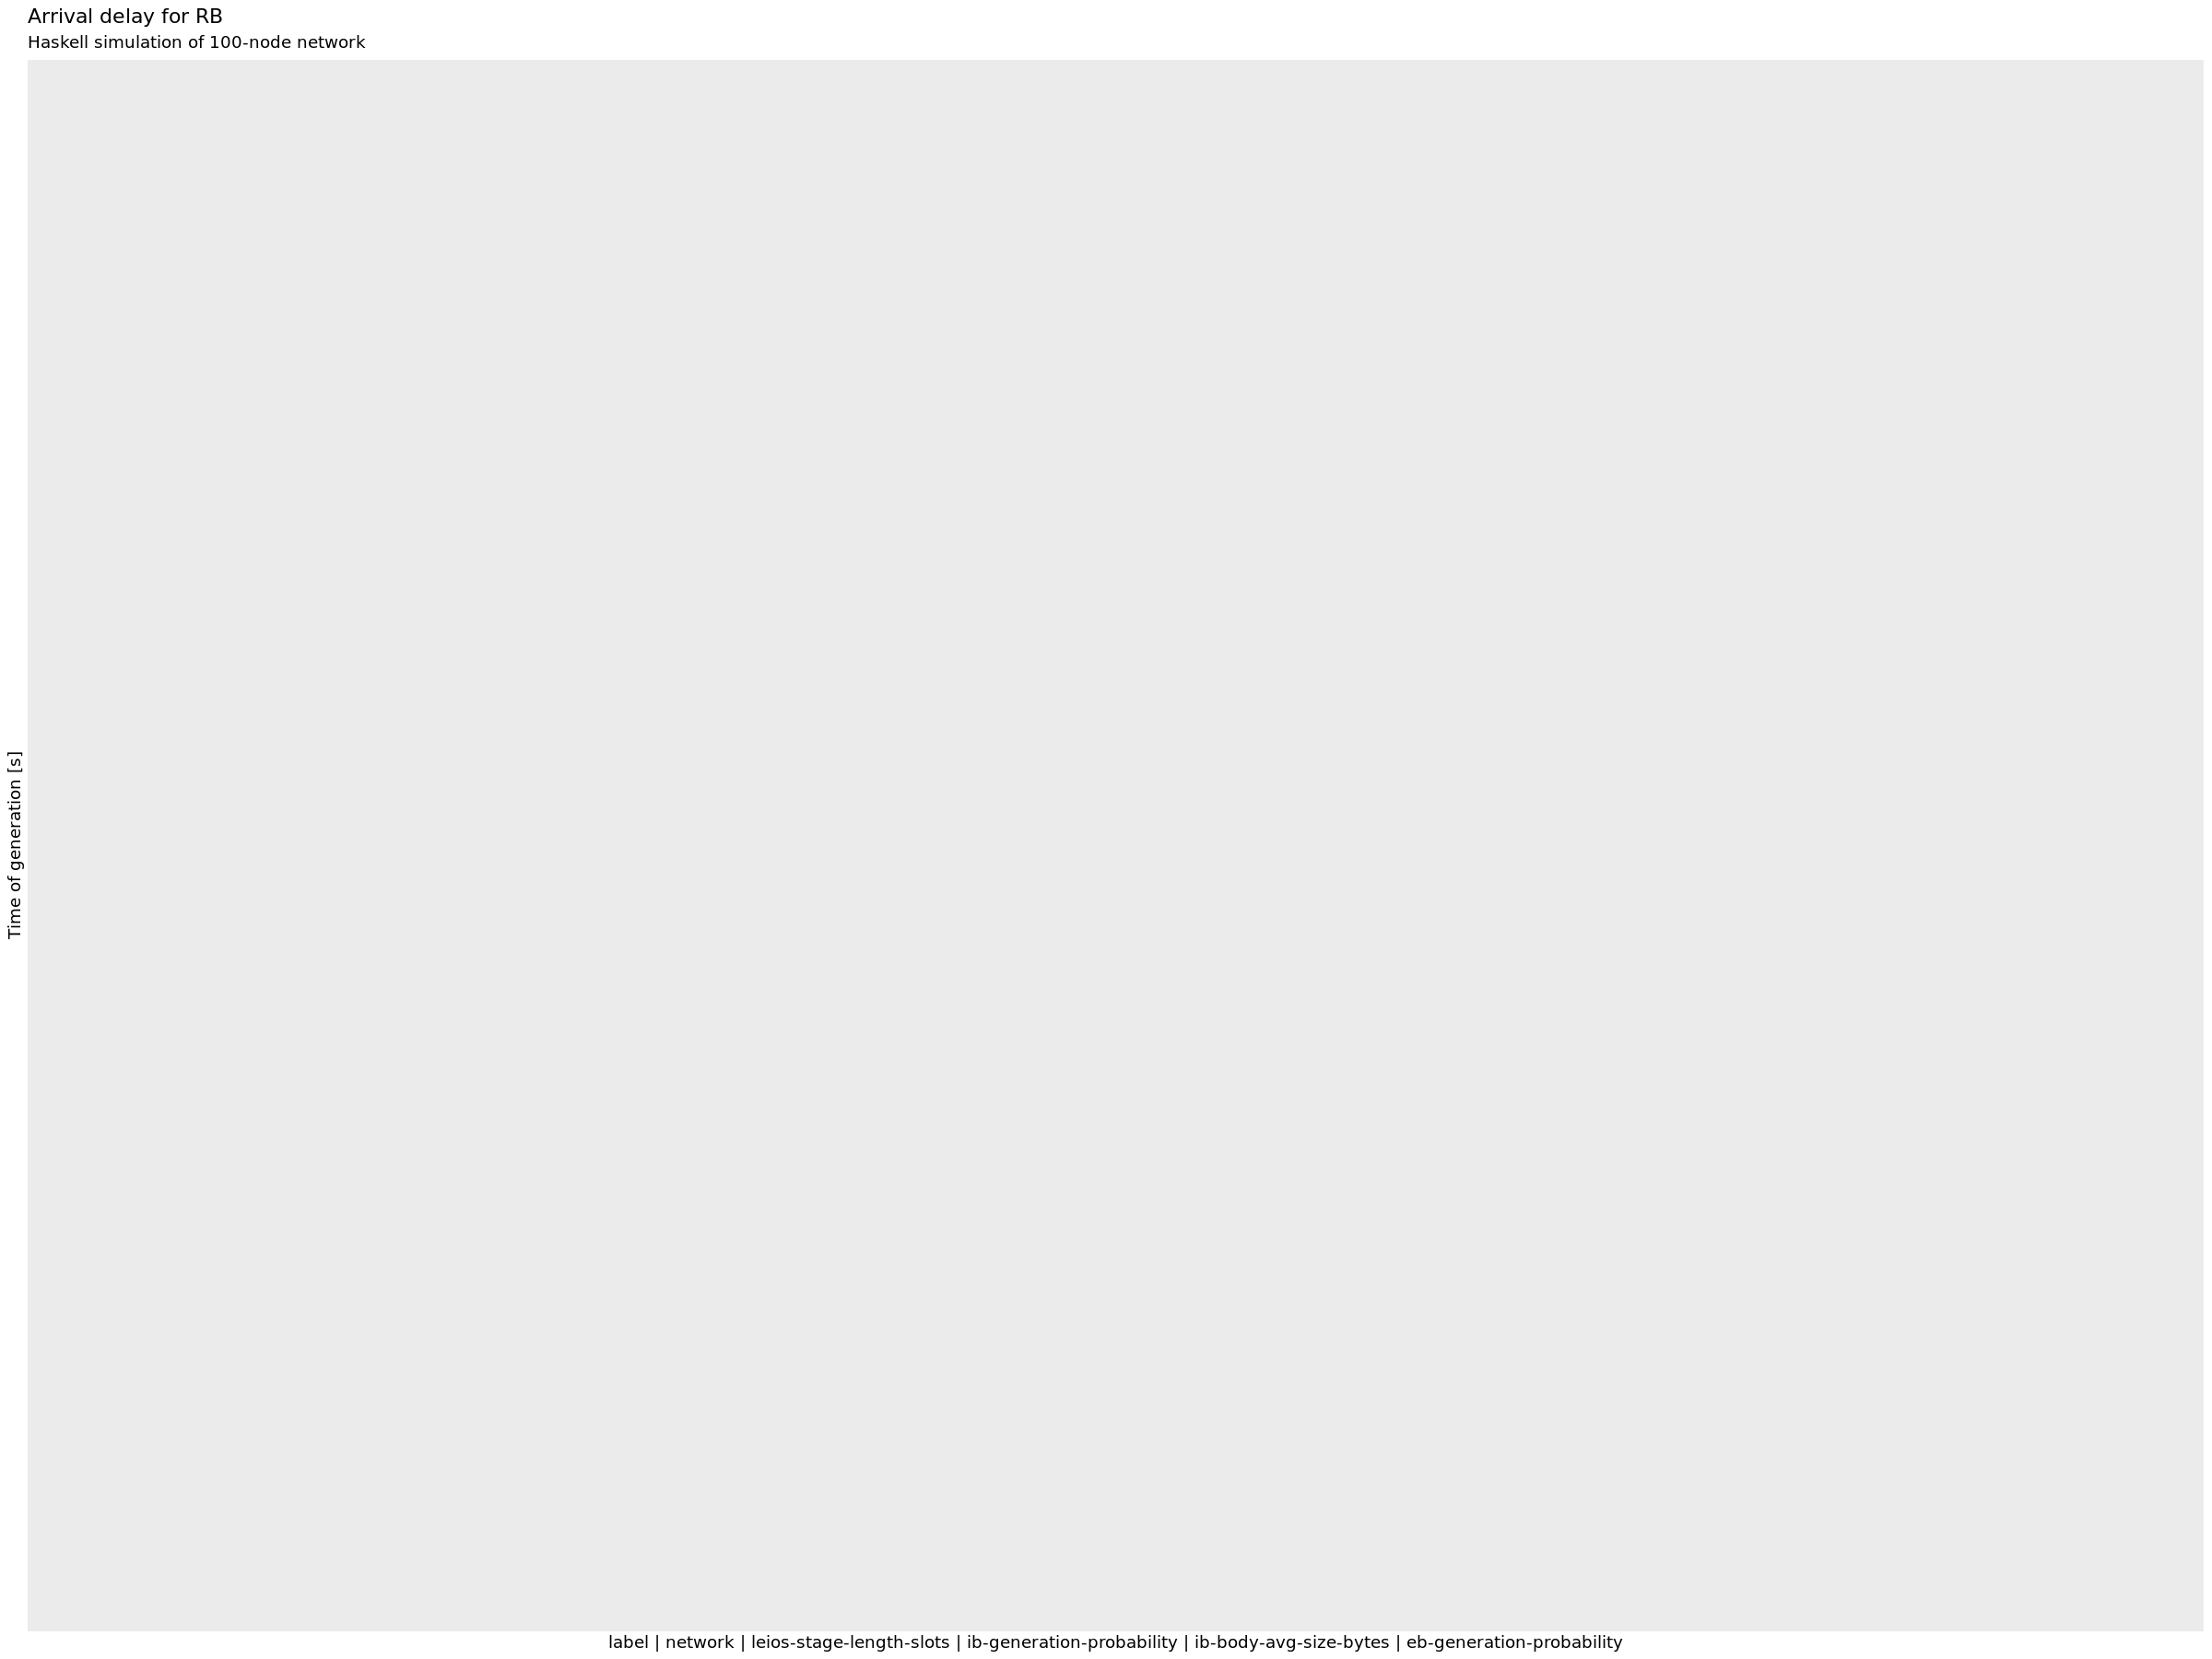

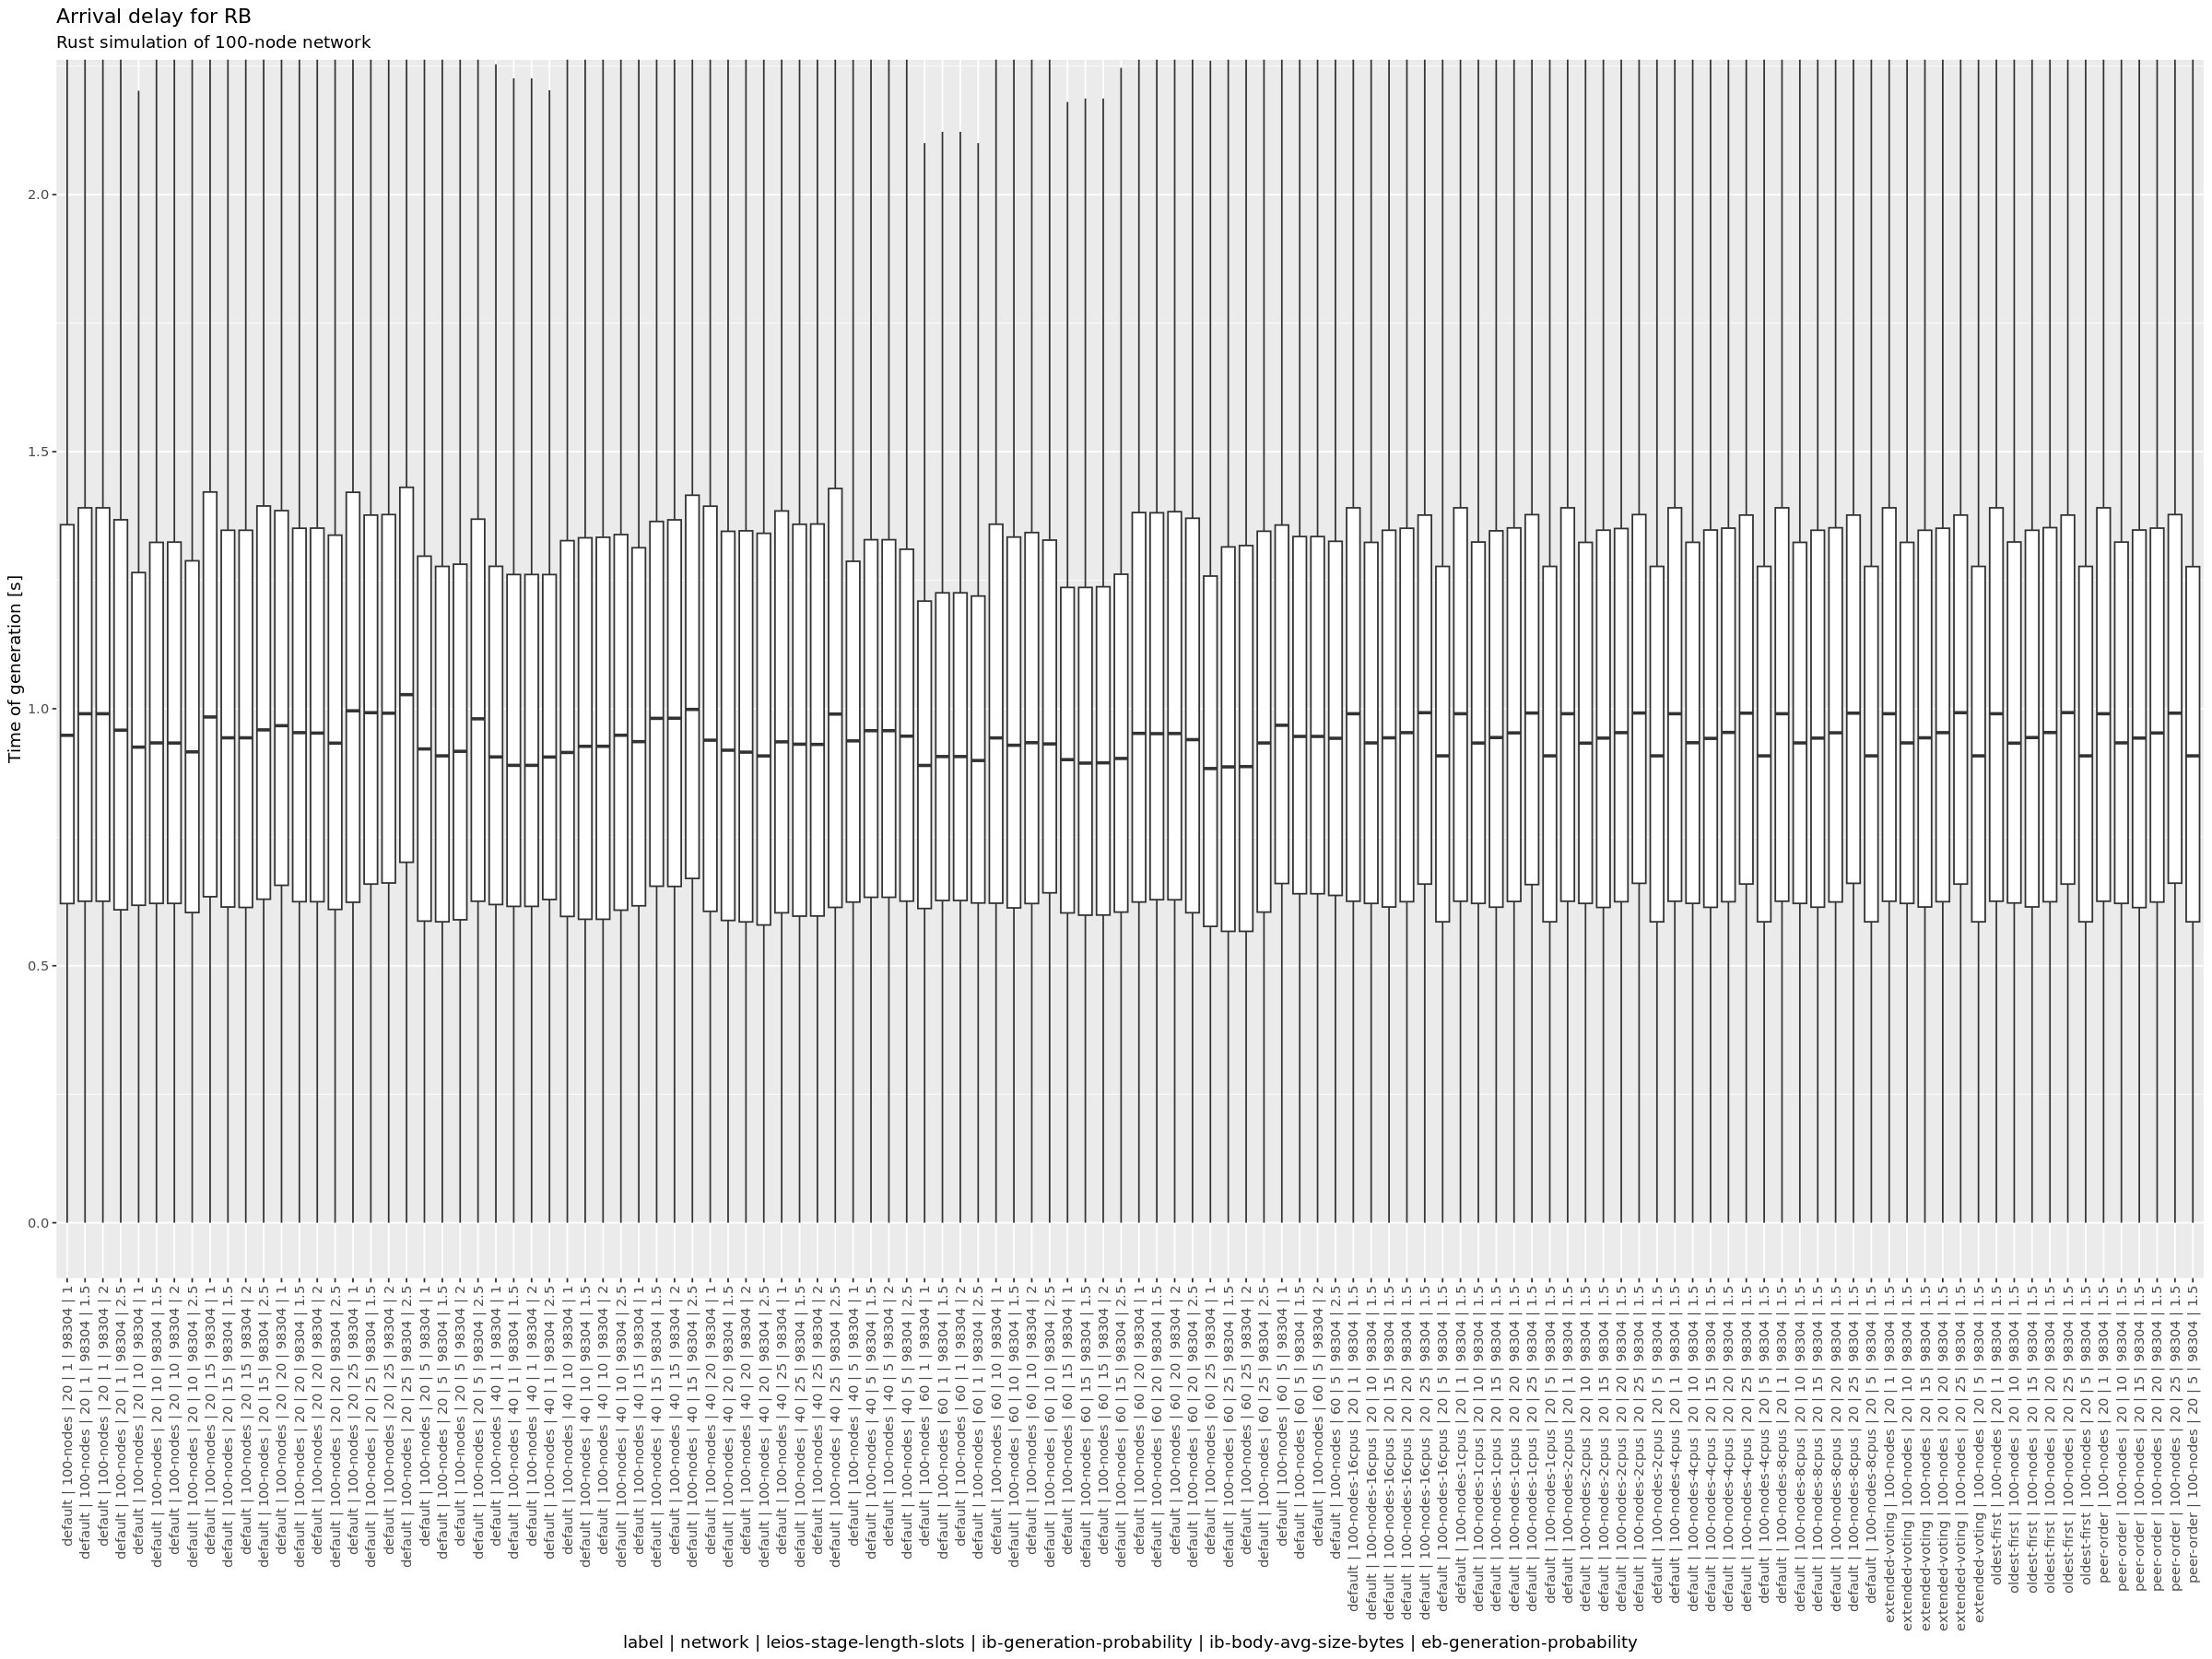

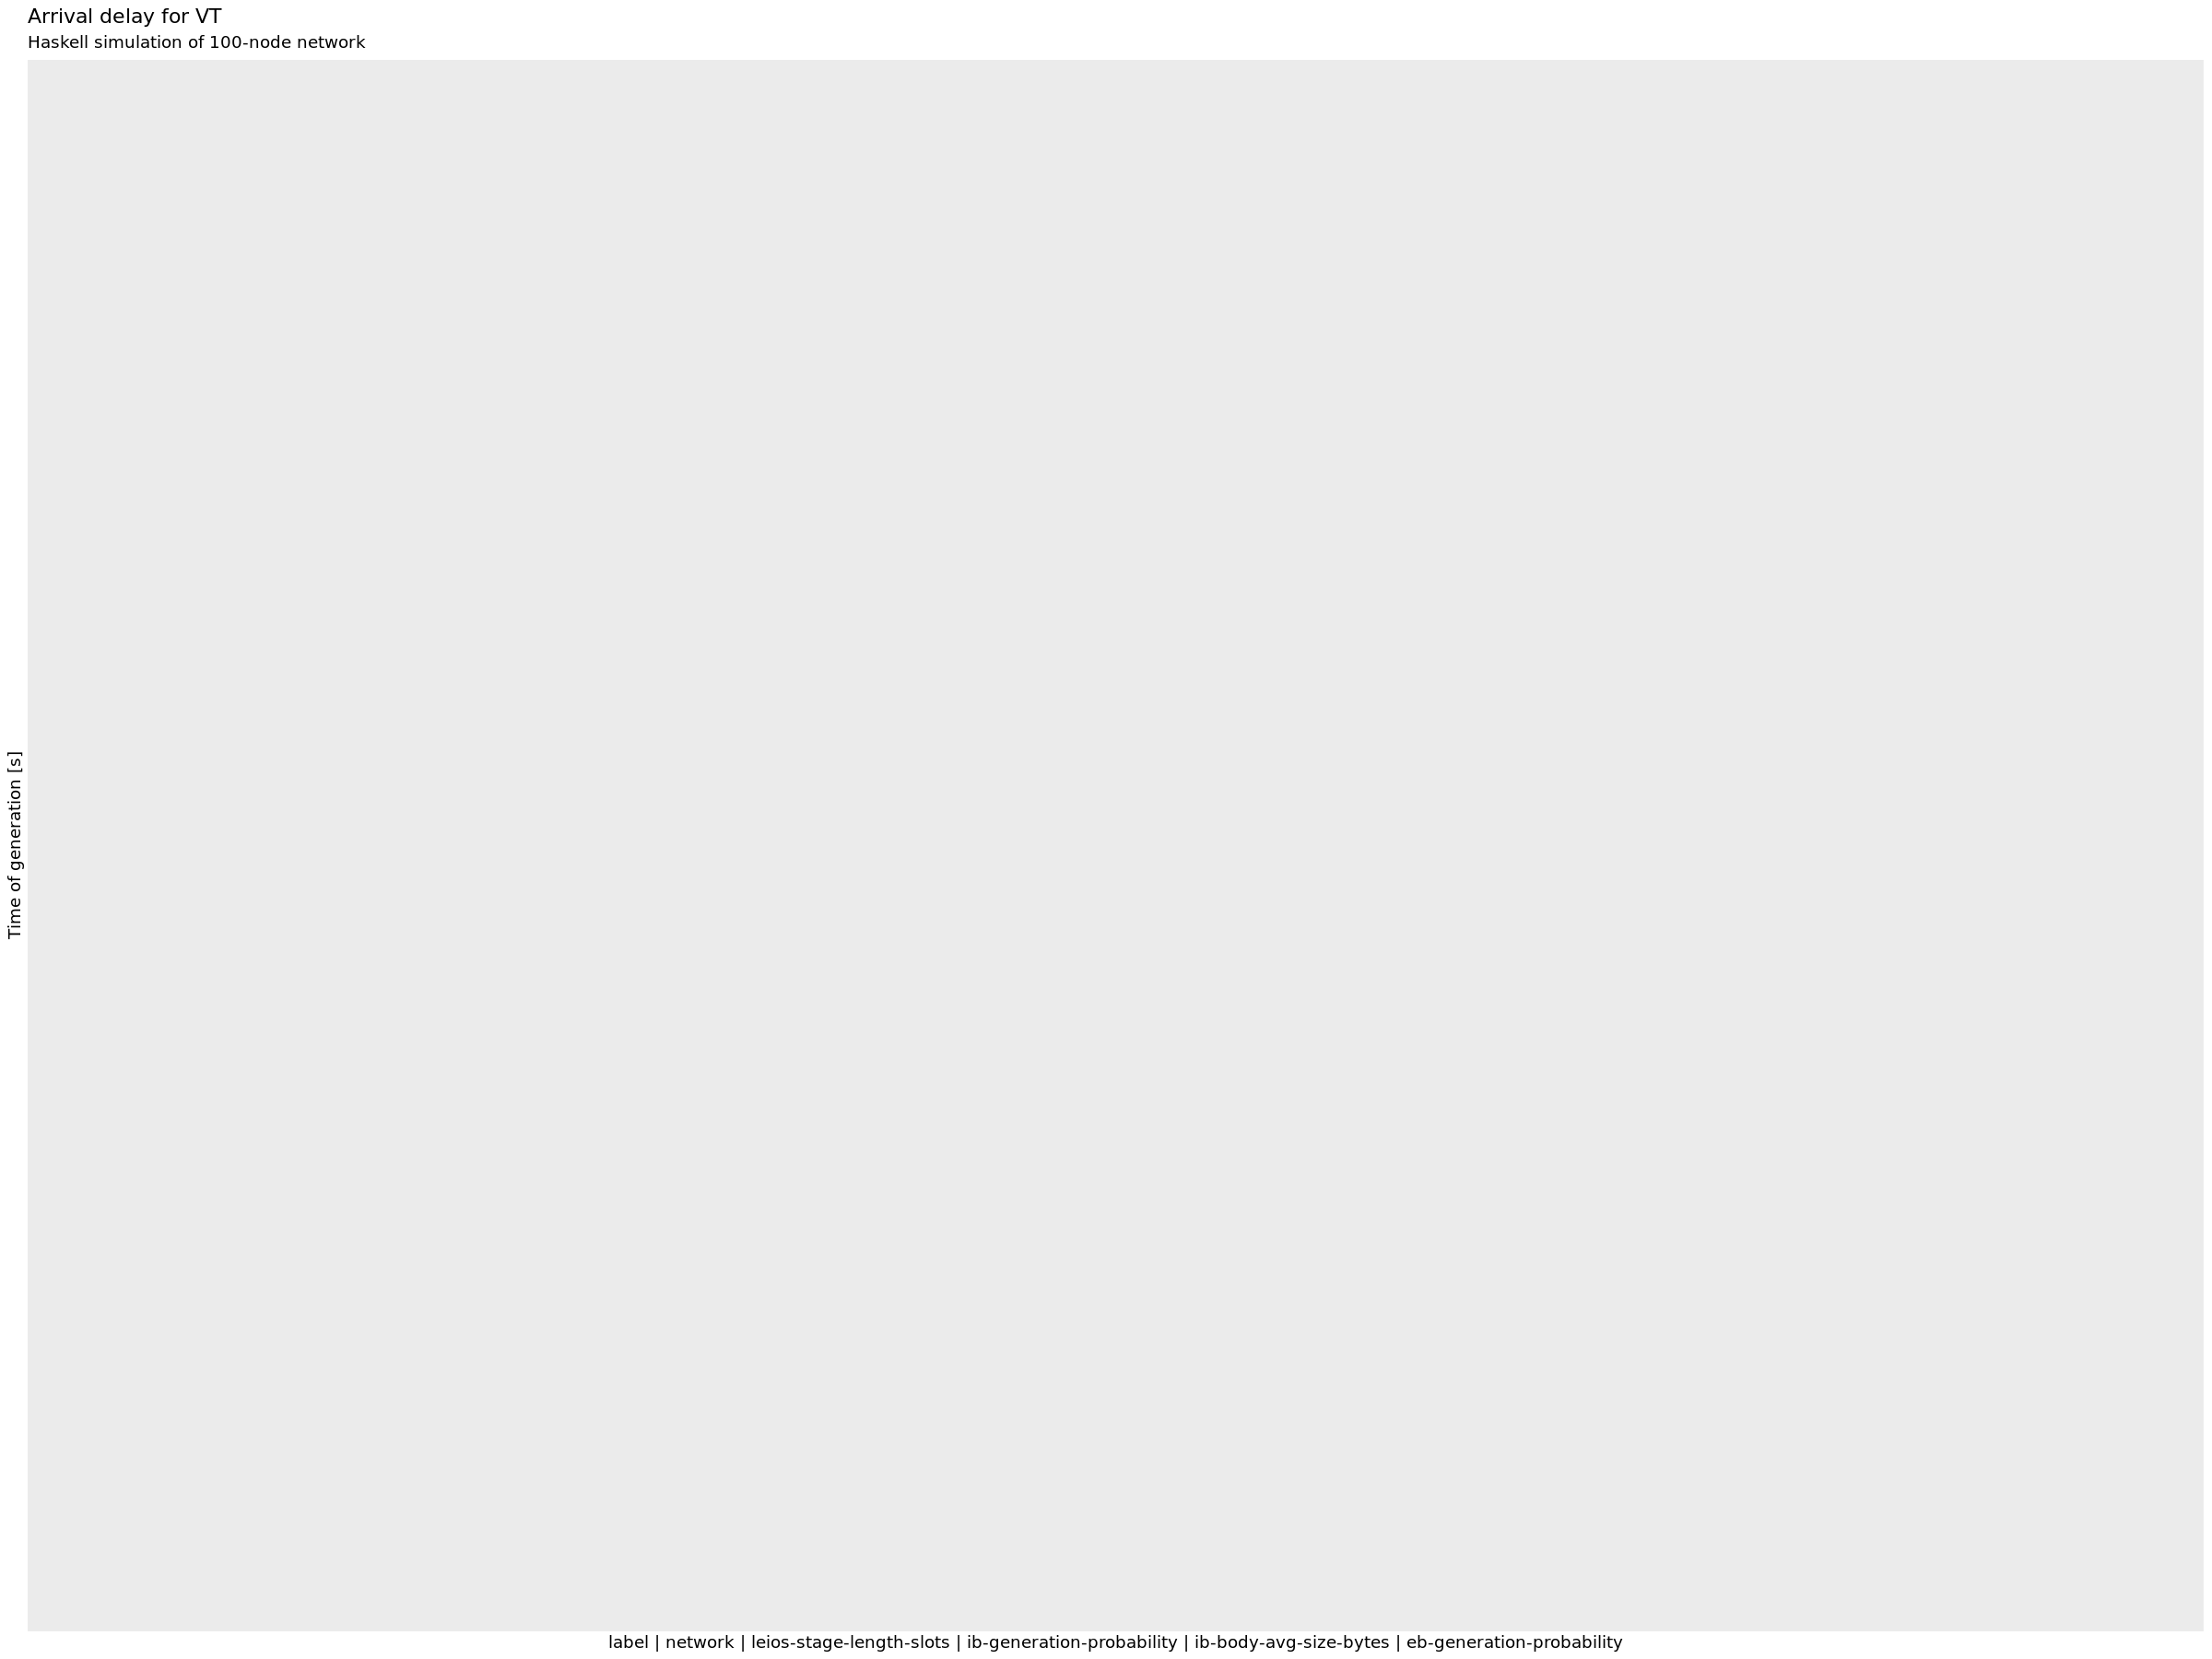

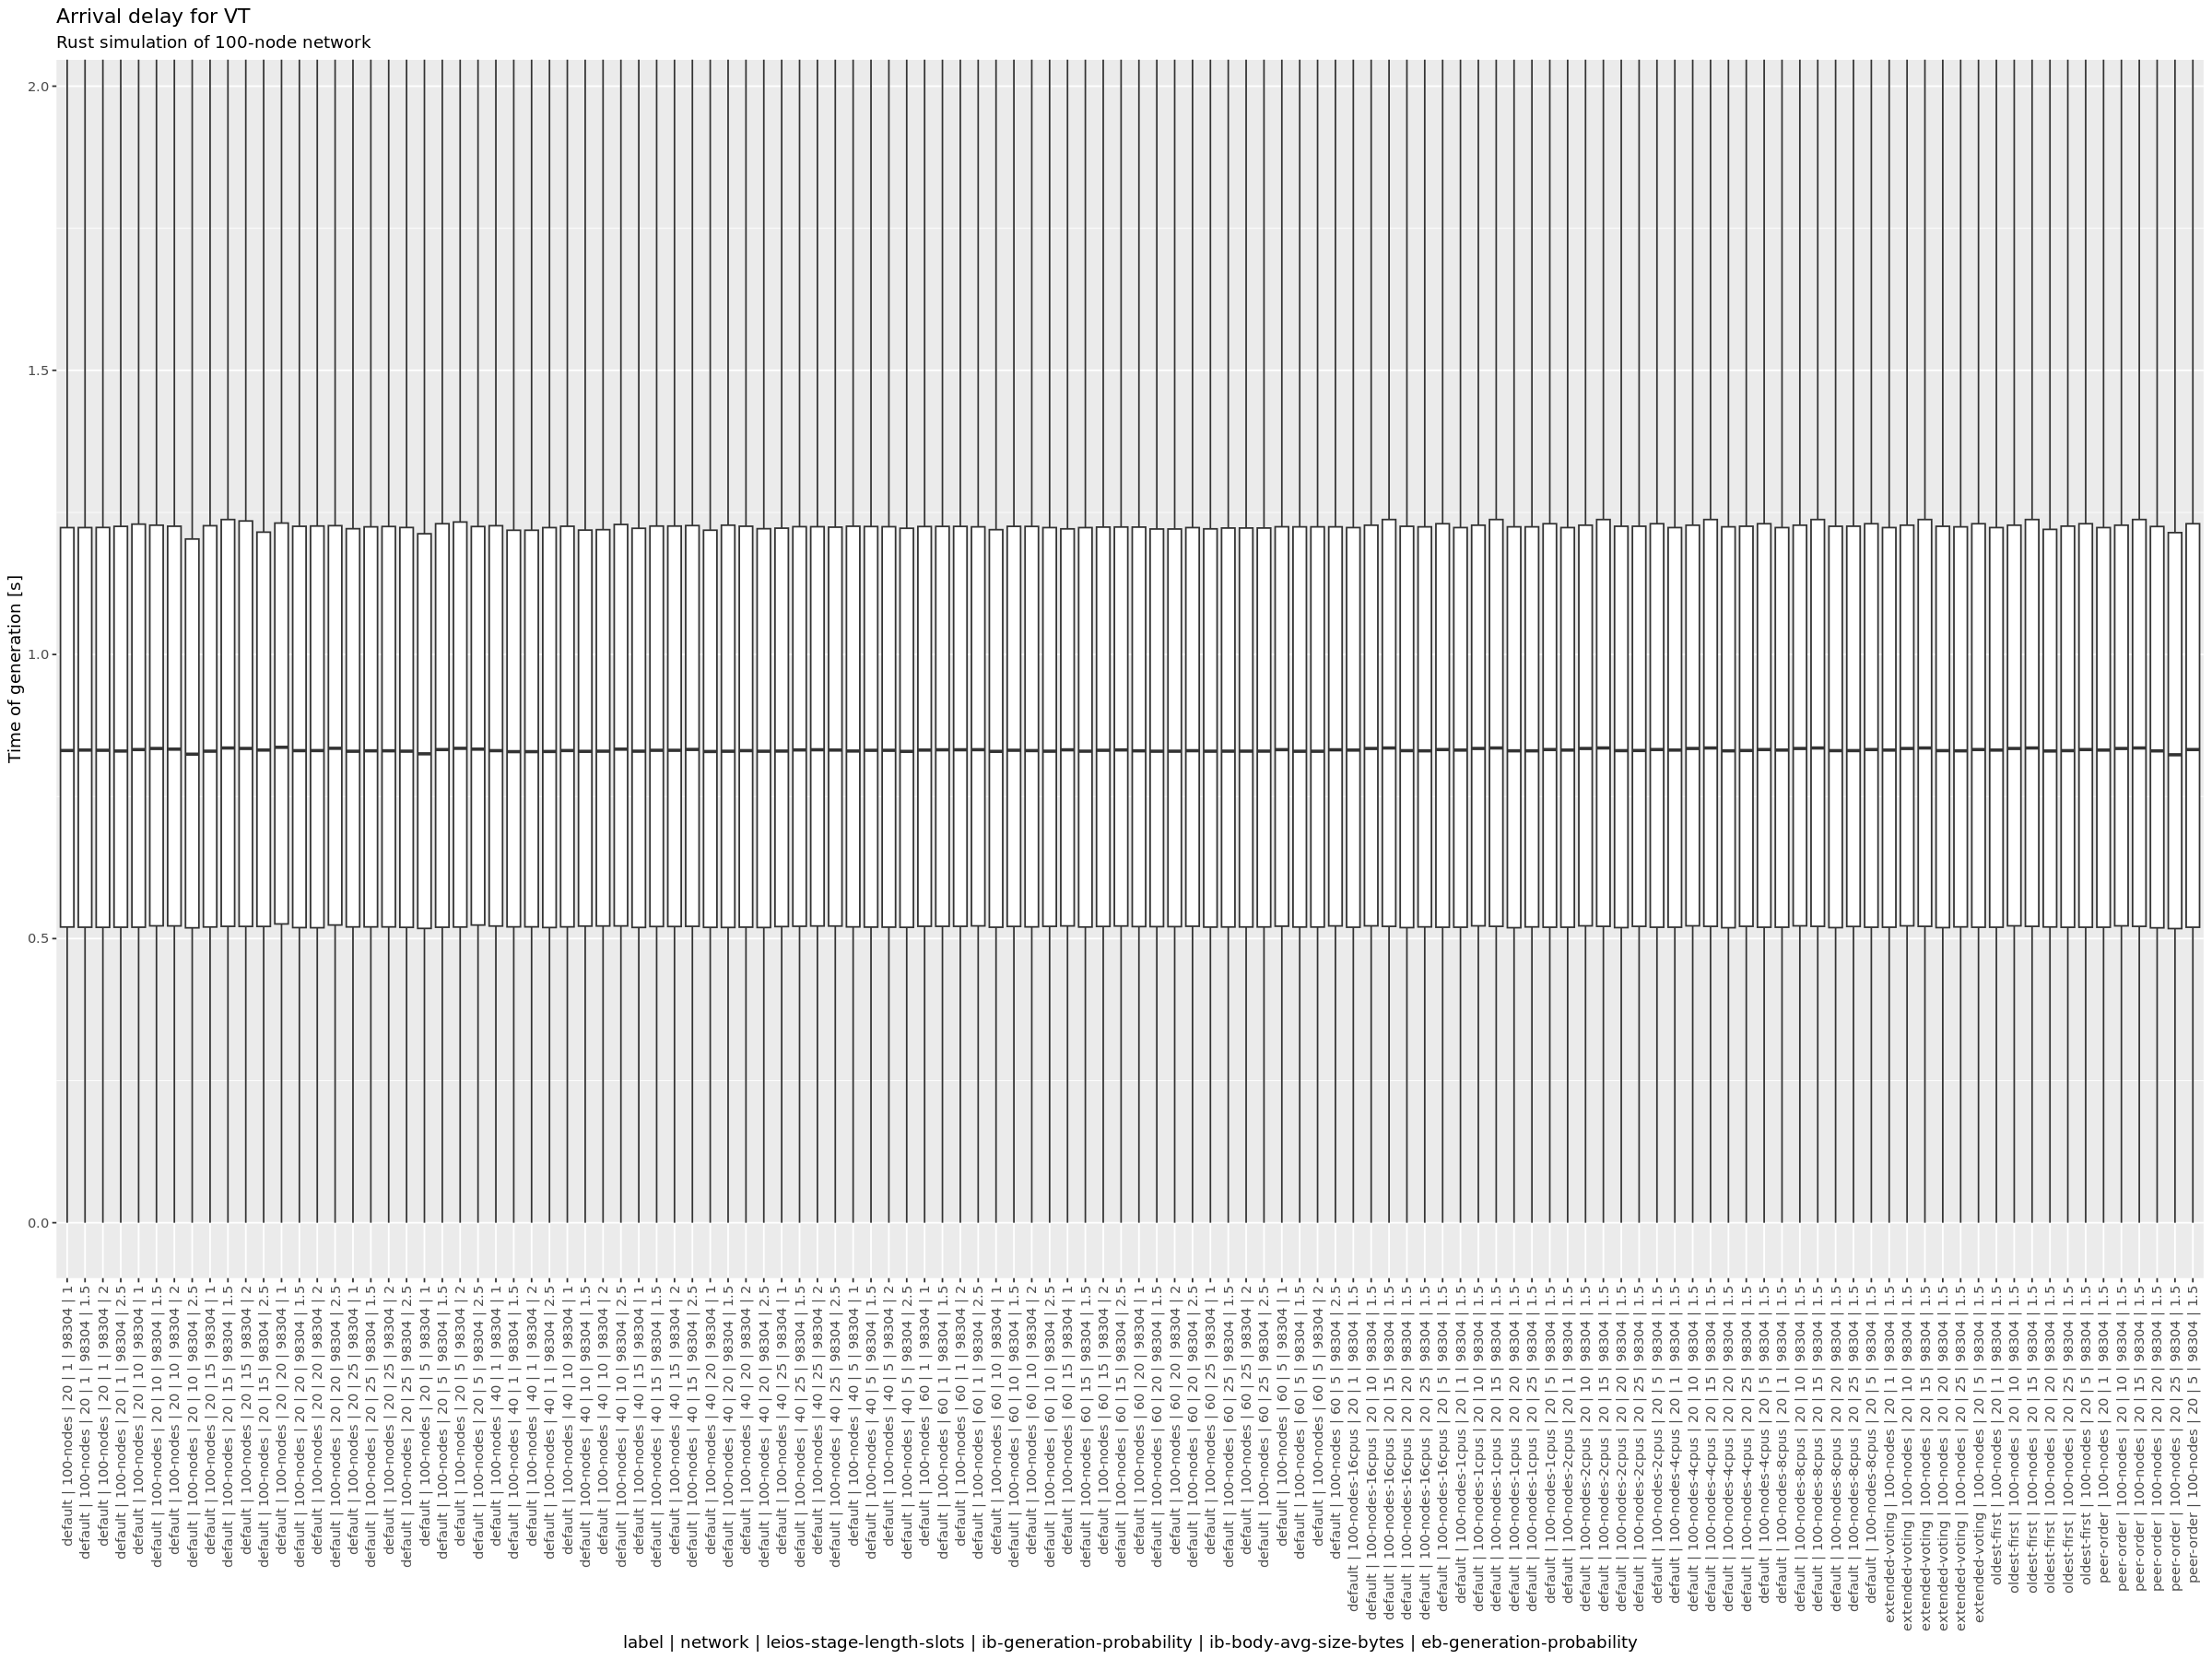

In [28]:
for (k in c("IB", "EB", "RB", "VT")) {
for (s in c("haskell", "rust")) {
    d <- receiptScenario[`simulator` == s & `kind` == k]
    g <- ggplot(d, aes(x=`scenario`, y=`elapsed`)) +
        geom_boxplot(outlier.shape=NA) +
        coord_cartesian(ylim=c(0, d[, quantile(`elapsed`, probs=0.99)])) +
        xlab("label | network | leios-stage-length-slots | ib-generation-probability | ib-body-avg-size-bytes | eb-generation-probability") +
        ylab("Time of generation [s]") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s %>% str_to_title, "simulation of 100-node network"))
    print(g)
    ggsave(paste0("plots/elapsed-boxplot-", k, "-", s, ".png"), units="in", width=15, height=6, dpi=150)
}
}